# Project milestone 2 for the group "Florence and the Machine"
Students names: Jangwon Park, Frank Schmutz, Frédéric Myotte, Caroline Moutiez <br/><br/>
In this notebook, you will find our deliverable for the milestone 2 of Ada course project.

## Table of contents
1. [Loading dataset](#Part-I:-Loading-dataset) 
2. [Cleaning tables](#Part-II:-Cleaning-tables) 
3. [Exploratory data analysis](#Part-III:-Exploratory-data-analysis) 
    1. [Products' price and sales over time](#A\)-Products'-price-and-sales-over-time)
    2. [Measuring price elasticity of demand](#B\)-Measuring-price-elasticity-of-demand)
    3. [Measuring complementarity between products](#C\)-Measuring-complementarity-between-products)
    4. [Effect of income and presence of children on food purchases](#D\)-Effect-of-income-and-presence-of-children-on-food-purchases)
4. [Discussions and plan for what comes next](#Part-IV:-Discussions-and-plan-for-what-comes-next)

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import scipy
from collections import Counter, OrderedDict
import itertools
import random

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# NLP-specific imports
import re
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Network analytics
import networkx as nx

# Other imports
import heapq
import warnings
warnings.filterwarnings('ignore')
SEED = 1

## Part I: Loading dataset

There are 8 tables in total whose details and relationships are illustrated in the figure below.

<img src="Milestone 2/dunnhumby db relations.png" width="700" height="700" align="center"/>

Information related to marketing campaigns and the details about which household redeemed which coupon are provided across four tables: `CAMPAIGN_TABLE`, `CAMPAIGN_DESC`, `COUPON_REDEMPT`, `COUPON`, and `CAUSAL_DATA`. For the exploratory data analysis part, we decided to focus more on the rest of the tables for cleaning and descriptive analysis, namely `HH_DEMOGRAPHIC`, `TRANSACTION_DATA`, and `PRODUCT`. This is because our research is centered around discovering the economics of food purchases, rather than operational aspects of the store, and in particular investigating: how to measure in an accurate way the degree to which products are complementary or substitutable in the microeconomics sense, and how income and presence of children affect food purchase decisions.

In [2]:
# Import tables
hh_demographic = pd.read_csv("dunnhumby/csv/hh_demographic.csv")
product = pd.read_csv("dunnhumby/csv/product.csv")
transaction_data = pd.read_csv("dunnhumby/csv/transaction_data.csv")

In [3]:
# Demographic information about each household
hh_demographic.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [4]:
# Product information
product.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [5]:
# Transaction records
transaction_data.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [6]:
# Checking sizes of the tables we are going to use
hh_demographic.shape, product.shape, transaction_data.shape

((801, 8), (92353, 7), (2595732, 12))

## Part II: Cleaning tables

In this part of the notebook, we are interested in achieving the following tasks:
1. **Find and address any missing values in each of the three tables**. <br/> In the `hh_demographic` table, for example, not all families who shop provided their personal information voluntarily. We want to see how many families in the `transaction_data` table actually have provided demographic information.
2. **Find and address non-sensical values**. <br/> Some transaction records, for example, will report purchased quantity of 0 and/or sales value of 0. As this implies no transaction for that product, we can remove these rows without incurring any loss of information.
3. **Some simple feature processing**. <br/> Again in the transaction records, for instance, we don't actually observe the *actual unit price* of each product. When they do, the actual unit price may be obscured by discounts and coupons. However, we can derive this using a simple formula presented in the User Guide pdf available on the Dunnhumby website.

#### Cleaning of transaction table

In [7]:
# Check for missing (null/na) data in "transaction_data"
for c in transaction_data.columns:
    print('Missing data in column "{}": {}'.format(c,sum(transaction_data[c].isnull())))

Missing data in column "household_key": 0
Missing data in column "BASKET_ID": 0
Missing data in column "DAY": 0
Missing data in column "PRODUCT_ID": 0
Missing data in column "QUANTITY": 0
Missing data in column "SALES_VALUE": 0
Missing data in column "STORE_ID": 0
Missing data in column "RETAIL_DISC": 0
Missing data in column "TRANS_TIME": 0
Missing data in column "WEEK_NO": 0
Missing data in column "COUPON_DISC": 0
Missing data in column "COUPON_MATCH_DISC": 0


We seem to have no missing data, but not all records are meaningful. An example of an invalid transaction record is when the quantity or sales value is 0.

In [8]:
# Check number of rows with QUANTITY == 0 or SALES_VALUE == 0
invalid_rows = transaction_data[(transaction_data.SALES_VALUE == 0) | (transaction_data.QUANTITY == 0)]
print('Number of rows to be removed: ', invalid_rows.shape[0])
invalid_rows.head()

Number of rows to be removed:  18917


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
97,744,26985165432,1,5978648,0,0.0,31582,0.0,1119,1,0.0,0.0
128,1287,26985336468,1,5978648,0,0.0,304,0.0,1351,1,0.0,0.0
249,2305,26996870743,2,5978656,0,0.0,414,0.0,1300,1,-1.0,0.0
293,271,26997082949,2,5978656,0,0.0,329,0.0,1719,1,-2.0,0.0
694,315,27008952267,3,957951,0,0.0,327,0.0,1707,1,0.0,0.0


In [9]:
# Removing these rows loses no information as they contain none.
transaction_data = transaction_data[~((transaction_data.SALES_VALUE == 0) | (transaction_data.QUANTITY == 0))]
transaction_data.shape

(2576815, 12)

There appears to be two kinds of actual unit prices: loyalty card price and non-loyalty card price. By definition, actual unit price derived from loyalty card holders (simply call this LCP) is always larger than or equal to that derived from non-loyalty card holders (call this NLCP) because loyalty card holders receive both the retrail as well as the coupon discounts whereas non-loyalty card holders receive only the latter. Therefore, when LCP > NLCP, we know that the true actual unit price equal to LCP; otherwise, LCP and NLCP should be equivalent and it doesn't matter which one we take.

In [10]:
# Calculate the actual unit product price (formula taken from the User Guide pdf)

# Loyalty card price (LCP)
LCP = (transaction_data.SALES_VALUE - (transaction_data.RETAIL_DISC + \
                                       transaction_data.COUPON_MATCH_DISC))/transaction_data.QUANTITY

# Non-loyalty card price (NLCP)
NLCP = (transaction_data.SALES_VALUE - transaction_data.COUPON_MATCH_DISC)/transaction_data.QUANTITY

# Confirm that there are no 0 quantities because if there were, some values would be nan.
print('Number of missing LCP values: ', sum(LCP.isnull()))
print('Number of missing NLCP values: ', sum(NLCP.isnull()))

Number of missing LCP values:  0
Number of missing NLCP values:  0


In [11]:
# Verify if LCP >= NCLP relationship is indeed true
transaction_data[LCP < NLCP]

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
1215551,1535,32478752229,370,999270,1,7.98,360,3.990000e+00,1852,54,0.0,0.0
1271754,623,32704598135,384,5995423,1,0.51,381,2.600000e-01,1950,56,0.0,0.0
1292342,59,32759986795,389,835530,1,2.50,352,4.440892e-16,1903,56,0.0,0.0
1466571,290,33362690334,433,9575181,2,0.66,367,1.110223e-16,1723,63,0.0,0.0
1785852,367,35080936104,512,10456655,4,1.00,368,1.110223e-16,1537,74,0.0,0.0


It turns out that there are **five rows** which violate the relationship LCP $\geq$ NLCP (out of ~2.5M rows). The common factor in these observations is that `RETAIL_DISC` is positive. A positive `RETAIL_DISC` implies that by applying the discount, the consumer would have paid a higher amount. This is clearly illogical as it would then not be a discount. Therefore, a more comprehensive search is to look for rows that have a positive value under `RETAIL_DISC`.

In [12]:
# Print rows with positive RETAIL_DISC
pos_retail_disc = transaction_data[transaction_data.RETAIL_DISC > 0]
pos_retail_disc

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
1215551,1535,32478752229,370,999270,1,7.98,360,3.990000e+00,1852,54,0.0,0.0
1271754,623,32704598135,384,5995423,1,0.51,381,2.600000e-01,1950,56,0.0,0.0
1292342,59,32759986795,389,835530,1,2.50,352,4.440892e-16,1903,56,0.0,0.0
1466571,290,33362690334,433,9575181,2,0.66,367,1.110223e-16,1723,63,0.0,0.0
1758882,367,34812010763,505,10456655,7,3.50,368,1.110223e-16,1413,73,0.0,0.0
1785852,367,35080936104,512,10456655,4,1.00,368,1.110223e-16,1537,74,0.0,0.0


The entries here effectively overlap with the rows that also have LCP < NLCP (which shouldn't happen). So we can attribute the violation of the "LCP $\geq$ NLCP" condition to the fact that these rows have positive `RETAIL_DISC`. The last four rows, however, don't really matter as their values of `RETAIL_DISC` is basically 0. The first two rows do matter, and we can investigate other rows with the same `PRODUCT_ID` within `TRANSACTION_DATA`.

In [13]:
# Display other rows with the same product ID
transaction_data[(transaction_data.PRODUCT_ID == 999270) & (transaction_data.DAY > 370)].head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
1217954,878,32493312069,371,999270,2,3.99,446,-3.99,1656,54,0.0,0.0
1220183,2084,32493651857,371,999270,2,3.99,389,-3.99,1538,54,0.0,0.0
1220253,210,32493652981,371,999270,2,3.99,389,-3.99,1832,54,0.0,0.0
1221185,1454,32505251935,372,999270,2,3.99,412,-3.99,1440,54,0.0,0.0
1221513,1579,32505311358,372,999270,2,3.99,388,-3.99,1354,54,0.0,0.0


In [14]:
# Display other rows with the same product ID
transaction_data[(transaction_data.PRODUCT_ID == 5995423) & (transaction_data.DAY > 380)].head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
1260616,742,32671515088,382,5995423,1,0.34,445,-0.26,832,55,0.0,0.0
1268604,468,32672365010,383,5995423,3,1.00,338,-0.79,215,55,0.0,0.0
1268605,468,32672365011,383,5995423,3,1.00,338,-0.79,216,55,0.0,0.0
1271754,623,32704598135,384,5995423,1,0.51,381,0.26,1950,56,0.0,0.0
1275551,636,32715925896,385,5995423,3,1.00,300,-0.79,1631,56,0.0,0.0


It appears that we can get the actual unit prices for the first "dirty" row by subtracting the positive `RETAIL_DISC`, thereby giving us 3.99, which matches the unit prices of the same product on similar days. On the other hand, the second "dirty" row seems to have unit prices around 0.60 on other similar days, but it is unclear whether how we can proceed (take the `SALES_VALUE` as is, or subtract `RETAIL_DISC`). Therefore, we choose to remove this second "dirty" row.

In [15]:
# Remove the second "dirty" row
transaction_data = transaction_data.drop([1271754])
transaction_data = transaction_data.reset_index(drop=True)
LCP = LCP.drop([1271754])
LCP = LCP.reset_index(drop=True)

In [16]:
# Create a new feature for the actual unit price (AUP)
transaction_data['AUP'] = LCP

#### Cleaning of the product table

In [17]:
# Check for missing (null/na) data in "product"
for c in product.columns:
    print('Missing data in column "{}": {}'.format(c,sum(product[c].isnull())))

Missing data in column "PRODUCT_ID": 0
Missing data in column "MANUFACTURER": 0
Missing data in column "DEPARTMENT": 0
Missing data in column "BRAND": 0
Missing data in column "COMMODITY_DESC": 0
Missing data in column "SUB_COMMODITY_DESC": 0
Missing data in column "CURR_SIZE_OF_PRODUCT": 0


In [18]:
# However, we know that many entries in the last column are empty
print('Number of empty entries in "CURR_SIZE_OF_PRODUCT": {}'.format((product.CURR_SIZE_OF_PRODUCT==' ').sum()))

Number of empty entries in "CURR_SIZE_OF_PRODUCT": 30607


Missing size of product is not a big deal as we may never use this column. However, there are products which are missing descriptions, so we have no idea what these product are. If we never learn what they are, there is little point is analyzing them economically either.

In [19]:
# Find out which products are missing commodity descriptions
missing_department  = product[product.DEPARTMENT==' ']
missing_department.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
52189,5126087,1,,National,,,
52190,5126088,1,,National,,,
52191,5126106,1,,National,,,
52192,5126107,1,,National,,,
55048,5977100,1,,National,,,


We suspect that these products may have already been taken care of when we removed transactions records with 0 quantities/sales value, which turns out to be true.

In [20]:
# Verify this hypothesis
sales = [transaction_data[transaction_data.PRODUCT_ID == p].SALES_VALUE.unique() \
             for p in missing_department.PRODUCT_ID.unique()]
print(sales) # everything is empty (i.e. not found)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]


#### Creating transactions table for which we have householders information

Here, we are interested in creating a new table of transactions where we remove the transactions for which we do not have any householder information, as this table would serve for further analyses.

In [21]:
keys_hh = set(hh_demographic.household_key.values)
keys_hh_tran = set(transaction_data.household_key.values)
len(keys_hh), len(keys_hh_tran)

(801, 2500)

In [22]:
# Removing transactions for which we don't have any householders information
transaction_data_hh = transaction_data[transaction_data.household_key.isin(keys_hh)]

In [23]:
# As we can see, we still have a good proportion of the transactions remaining
len(transaction_data), len(transaction_data_hh)

(2576814, 1416671)

## Part III: Exploratory data analysis

### A) Products' price and sales over time

To analyze economic relationships later on, we need to look at each products' price and sales over time. One choice is to use `WEEK_NO` as discrete time points. As there are 2 years worth of data, this gives us about max. 100 points in time. However, the actual unit price for a given product may or may not be the same in the same week. We can deal with this by computing the weekly mean actual unit price.

In [24]:
# Filter columns we do not need
filtered_trans = transaction_data[['WEEK_NO','PRODUCT_ID','QUANTITY','AUP']].copy()

# Save basket information for possible later use
baskets = transaction_data[['BASKET_ID', 'PRODUCT_ID']].copy()

# Compute mean AUP per product per week
quantity_sum = filtered_trans.groupby(['WEEK_NO','PRODUCT_ID']).agg('sum')['QUANTITY']
mean_aup = filtered_trans.groupby(['WEEK_NO','PRODUCT_ID']).agg('mean')['AUP']

# Create the dataframe to analyze in further sections of this notebook
df = pd.concat([quantity_sum, mean_aup], axis=1).reset_index()   # Unravels the multi-index into columns
df = df.sort_values(by='WEEK_NO', axis=0).reset_index(drop=True) # Sort chronologically
df.head()

,WEEK_NO,PRODUCT_ID,QUANTITY,AUP
0,1,39592,2,3.39
1,1,1088112,2,1.29
2,1,1087347,1,0.25
3,1,1087106,1,3.49
4,1,1086727,1,5.99


Not all products are bought regularly. So we need to find out which are scarcely purchased.

In [25]:
# Not all products are bought regularly, we find out which products are "scarcely" purchased below
num_weekly_trans = Counter(df.PRODUCT_ID)

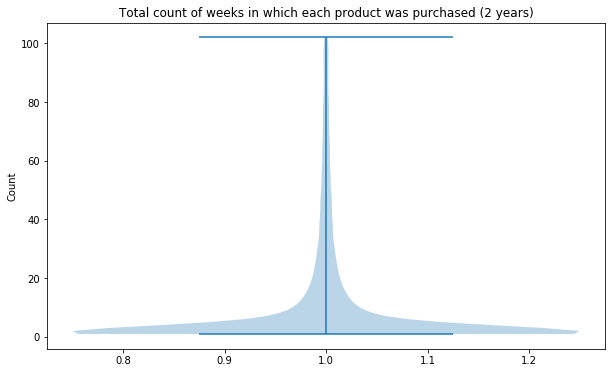

In [26]:
# Visualize the scarcity of purchases
fig = plt.figure(figsize=(10,6))
plt.violinplot(num_weekly_trans.values())
plt.title('Total count of weeks in which each product was purchased (2 years)')
plt.ylabel('Count')
plt.show()

In [27]:
# Find out how many products are bought just once
products_bought_once = [x for x,c in num_weekly_trans.items() if c == 1]
products_bought_twice = [x for x,c in num_weekly_trans.items() if c == 2]
print('% of products bought only once in 2 years: {0:.0f}%'.format(100*len(products_bought_once)/len(num_weekly_trans)))
print('% of products bought only twice in 2 years: {0:.0f}%'.format(100*len(products_bought_twice)/len(num_weekly_trans)))

% of products bought only once in 2 years: 37%
% of products bought only twice in 2 years: 13%


We now know that exactly 50% of all products have been bought only once or twice in 2 years. This is problematic because we expect that in reality some products are necessity good i.e. bought on a weekly basis like food and vegetables, but the above suggests that there are almost no such products.

In [28]:
# Look at what some of these scarce products are
tmp = pd.DataFrame()
for i in range(5):
    id = products_bought_once[i]
    tmp = pd.concat([tmp, product[product.PRODUCT_ID==id]], axis=0)
tmp

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
383,39592,69,DRUG GM,Private,SOAP - LIQUID & BAR,BAR SOAP,25.5 OZ
36127,1087347,544,GROCERY,National,BAG SNACKS,SGL SV/VEND MACH SNACKS CHIP/P,.875 OZ
36541,1090975,58,DRUG GM,National,CANDY - PACKAGED,SEASONAL CANDY BAGS-CHOCOLATE,12 OZ
34580,1073745,693,DRUG GM,National,CANDY - PACKAGED,SEASONAL MISCELLANEOUS,6 PK
34529,1073191,58,DRUG GM,National,CANDY - PACKAGED,SEASONAL CANDY BAGS-CHOCOLATE,12 OZ


We can notice the third and the last items, despite having everthing equal, are somehow treated as separate products. So it's worth looking at all products from manufacturer number 58.

In [29]:
# Look at all candy products made by manufacturer 58
is_candy_bar = product[product.MANUFACTURER == 58]['SUB_COMMODITY_DESC'].apply(lambda x: 'CANDY BAR' in x)

product[(product.MANUFACTURER == 58) & (is_candy_bar)].head(10)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
722,48451,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,1.4 OZ
4684,598890,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,
6648,826099,58,DRUG GM,National,CANDY - PACKAGED,CANDY BARS (MULTI PACK),6 PK
14247,893399,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,
15038,900185,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,1.4 OZ
17167,918772,58,DRUG GM,National,CANDY - PACKAGED,CANDY BARS (MULTI PACK),6 PK
24520,984087,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,
28439,1018679,58,DRUG GM,National,CANDY - PACKAGED,CANDY BARS (SINGLES)(INCLUDING,4 OZ
32641,1056014,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,
36754,1092948,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,1.85 OZ


These are just ten items which, despite being candy bars from the same manufacturer, are all unique products. Therefore, it will be useful to analyze, not each product id, but each "commodity" category for further analysis. 

In [30]:
# Join df with product to get commodity descriptions
df_merged = df.join(product.set_index('PRODUCT_ID'), on='PRODUCT_ID', how='left')

# Join basket df with product also to get commodity descriptions (for later use)
df_baskets = baskets.join(product.set_index('PRODUCT_ID'), on='PRODUCT_ID', how='left')

df_merged.head()

,WEEK_NO,PRODUCT_ID,QUANTITY,AUP,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,1,39592,2,3.39,69,DRUG GM,Private,SOAP - LIQUID & BAR,BAR SOAP,25.5 OZ
1,1,1088112,2,1.29,5136,GROCERY,National,VEGETABLES - SHELF STABLE,SPINACH & GREENS,14 OZ
2,1,1087347,1,0.25,544,GROCERY,National,BAG SNACKS,SGL SV/VEND MACH SNACKS CHIP/P,.875 OZ
3,1,1087106,1,3.49,1441,PRODUCE,National,PROCESSED,DRESSINGS,15 OZ
4,1,1086727,1,5.99,764,GROCERY,National,LAUNDRY ADDITIVES,FABRIC SOFTENER SHEETS,120 CT


In [31]:
# Again aggregate quantities and AUP
quantity_sum = df_merged.groupby(['WEEK_NO','COMMODITY_DESC']).agg('sum')['QUANTITY']
mean_aup = df_merged.groupby(['WEEK_NO','COMMODITY_DESC']).agg('mean')['AUP']

df_merged = pd.concat([quantity_sum, mean_aup], axis = 1).reset_index()   # Unravels the multiindex into columns
df_merged = df_merged.sort_values(by='WEEK_NO', axis = 0).reset_index(drop=True) # Sort chronologically
print('New shape: ', df_merged.shape)
# print('Number of unique "products" (subcommodities): ', len(df_merged.SUB_COMMODITY_DESC.unique()))
print('Number of unique "products" (commodities): ', len(df_merged.COMMODITY_DESC.unique()))
df_merged.head()

New shape:  (27453, 4)
Number of unique "products" (commodities):  307


,WEEK_NO,COMMODITY_DESC,QUANTITY,AUP
0,1,ADULT INCONTINENCE,1,3.490
1,1,MELONS,2,2.290
2,1,MILK BY-PRODUCTS,26,2.055
3,1,MISC WINE,2,3.490
4,1,MISC. DAIRY,7,2.390


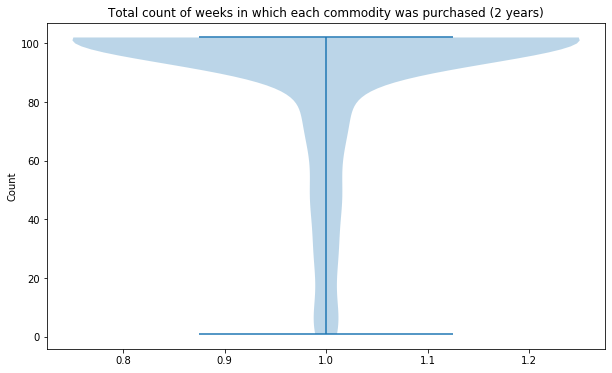

In [32]:
# Visualize the weekly puchases again
num_weekly_trans_merged = Counter(df_merged.COMMODITY_DESC)
fig = plt.figure(figsize = (10,6))
plt.violinplot(num_weekly_trans_merged.values())
plt.title('Total count of weeks in which each commodity was purchased (2 years)')
plt.ylabel('Count')
plt.show()

This distribution is a lot more representative of the reality for a few reasons. First, we have many "products" which are bought almost on a weekly basis. Some examples could be pizza or pancake mix. In the middle we have several "products" which are bought equally frequently, on a more or less biweekly basis. Then we still have some, but considerably fewer, non-common goods which are scarcely bought such as a tricycle or barbeque grills.

In [33]:
# Find which products are bought almost every week
weekly_bought_products = [x for x,y in OrderedDict(num_weekly_trans_merged).items() if y >= 102]
print('Ten items which are bought weekly: \n', weekly_bought_products[:10])

# Find whici products are bought rarely
rare_products = [x for x,y in OrderedDict(num_weekly_trans_merged).items() if y < 2]
print('\nTen items which are bought rarely: \n', rare_products[:10])

Ten items which are bought weekly: 
 ['MELONS', 'MILK BY-PRODUCTS', 'MISC WINE', 'MISC. DAIRY', 'MISCELLANEOUS', 'MOLASSES/SYRUP/PANCAKE MIXS', 'MUSHROOMS', 'NO COMMODITY DESCRIPTION', 'OLIVES', 'ONIONS']

Ten items which are bought rarely: 
 ['MISCELLANEOUS(CORP USE ONLY)', 'EASTER LILY', 'MISCELLANEOUS CROUTONS', 'FROZEN PACKAGE MEAT']


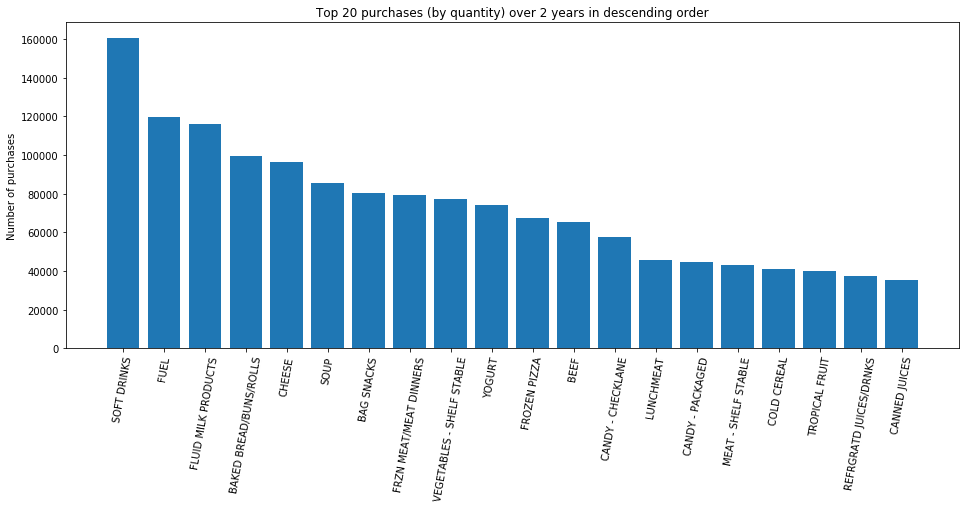

In [34]:
# Find most bought products over 2 years
qty_sorted = df_merged.groupby('COMMODITY_DESC').agg('sum')['QUANTITY'].sort_values(ascending = False)
N = 20
fig,ax = plt.subplots(figsize = (16,6))
ax.bar(np.arange(0,N,1), qty_sorted.iloc[1:N+1].values)
ax.set_xticks(np.arange(0,N,1))
ax.set_xticklabels(qty_sorted.index[1:N+1],rotation = 80)
ax.set_ylabel('Number of purchases')
ax.set_title('Top 20 purchases (by quantity) over 2 years in descending order')
plt.show()

Above excludes gasoline since its 'quantities sold' are overwhemingly high compared to the rest.

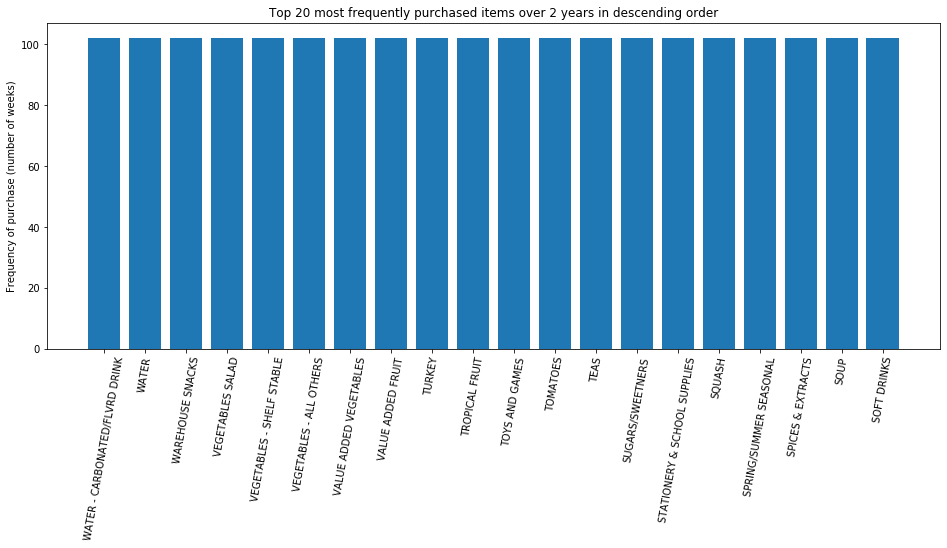

In [35]:
# Find most frequently bought items over 2 years
weekly_item_count = Counter(df_merged.COMMODITY_DESC)

sorted_count = sorted(zip(weekly_item_count.values(),weekly_item_count.keys()), reverse=True)
freq_items = [i[1] for i in sorted_count]
freq_counts = [i[0] for i in sorted_count]

N = 20
fig,ax = plt.subplots(figsize = (16,6))
ax.bar(np.arange(0,N,1), freq_counts[1:N+1])
ax.set_xticks(np.arange(0,N,1))
ax.set_xticklabels(freq_items[1:N+1],rotation = 80)
ax.set_ylabel('Frequency of purchase (number of weeks)')
ax.set_title('Top 20 most frequently purchased items over 2 years in descending order')
plt.show()

Most quantities sold is in general not equal to whether or not the product is purchased every week.

### B) Measuring price elasticity of demand
First, we can measure each products' *elasticity of demand*, which describes the **percent change in quantity demanded followed by 1% change in its price**. To this end, we can follow these steps:
1. Select a product and filter the dataframe for its unique ID (`PRODUCT_ID` column).
2. Compute the elasticities between every pair of adjacent discrete time points (using `WEEK_NO`), which will produce X number of values. 
3. Produce an average of X elasticities. 
4. Repeat for all other products.

In [36]:
# Let's compute the price elasticity of demand for a few products
product_elasticity = {}

for item in df_merged.COMMODITY_DESC.unique()[:10]:
    item_df = df_merged[df_merged.COMMODITY_DESC == item]
    item_elasticity = []
    
    num_weeks = len(item_df)
    if num_weeks > 1:
        previous_week = item_df.iloc[0]
        for i in range(num_weeks):
            current_week = item_df.iloc[i]
            
            if current_week.AUP != previous_week.AUP:
                percent_price_change = (current_week.AUP / previous_week.AUP - 1) * 100
                elasticity = (current_week.QUANTITY / previous_week.QUANTITY - 1)  * 100 / percent_price_change
                item_elasticity.append(elasticity)
            
            previous_week = current_week
    
    if len(item_elasticity) > 0:
        product_elasticity[item] = np.mean(item_elasticity)

In [37]:
product_elasticity

{'ADULT INCONTINENCE': 1.1697906608476794,
 'MELONS': 157858131268647.8,
 'MILK BY-PRODUCTS': -11.31634872479654,
 'MISC WINE': -7.632926532032537,
 'MISC. DAIRY': -19988663419534.56,
 'MISCELLANEOUS': 0.03245405040356183,
 'MOLASSES/SYRUP/PANCAKE MIXS': -3.8612535941506096,
 'MUSHROOMS': -0.05175853794461483,
 'NO COMMODITY DESCRIPTION': -0.419492170995051,
 'OLIVES': 29.81663138881084}

Using the initially proposed method, we find that there is so much variation in the data that the elasticities do not make any sense. As an alternative, let's try to *group by AUP*, take the mean quantities for each AUP and perform linear regression. The slope of the linear regression model will describe the average change in quantities with price and hence yields a natural interpretation of elasticity.

In [38]:
def plot_price_and_quantity(item):
    item_df = df_merged[df_merged.COMMODITY_DESC == item]
    y = item_df.groupby('AUP').agg('mean')['QUANTITY']
    x = y.index
    plt.figure(figsize=(10, 3))
    plt.title(item + ' elasticity')
    plt.scatter(x, y)
    plt.xlabel('AUP')
    plt.ylabel('QUANTITY')
    
    line_fit = np.polyfit(x, y, 1)
    line = np.poly1d(line_fit)
    
    # Compute elasticity
    min_price = np.unique(x).min()
    max_price = np.unique(x).max()
    min_qty = line(min_price)
    max_qty = line(max_price)
    
    percent_price_increase = (max_price / min_price - 1) * 100
    elasticity = (max_qty / min_qty - 1) * 100 / percent_price_increase
    
    plt.title(item + '\nElasticity: ' + str(np.round(elasticity, 2)))
    
    plt.plot(np.unique(x), np.poly1d(line_fit)(np.unique(x)), color='red')

In [39]:
df_merged.COMMODITY_DESC.unique()[:20]

array(['ADULT INCONTINENCE', 'MELONS', 'MILK BY-PRODUCTS', 'MISC WINE',
       'MISC. DAIRY', 'MISCELLANEOUS', 'MOLASSES/SYRUP/PANCAKE MIXS',
       'MUSHROOMS', 'NO COMMODITY DESCRIPTION', 'OLIVES', 'ONIONS',
       'ORAL HYGIENE PRODUCTS', 'ORGANICS FRUIT & VEGETABLES',
       'PAPER HOUSEWARES', 'PAPER TOWELS', 'PASTA SAUCE', 'PEPPERS-ALL',
       'PET CARE SUPPLIES', 'PICKLE/RELISH/PKLD VEG', 'PIES'],
      dtype=object)

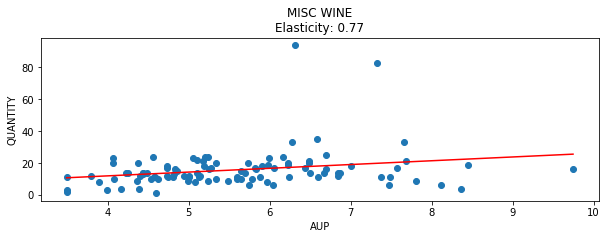

In [40]:
plot_price_and_quantity('MISC WINE')

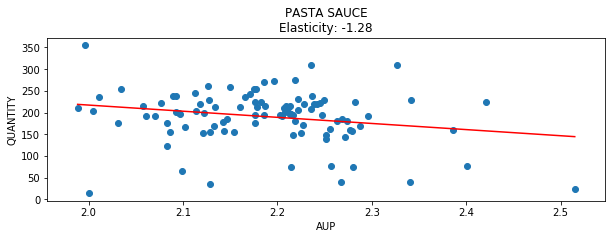

In [41]:
plot_price_and_quantity('PASTA SAUCE')

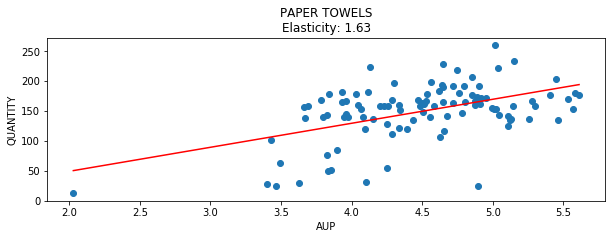

In [42]:
plot_price_and_quantity('PAPER TOWELS')

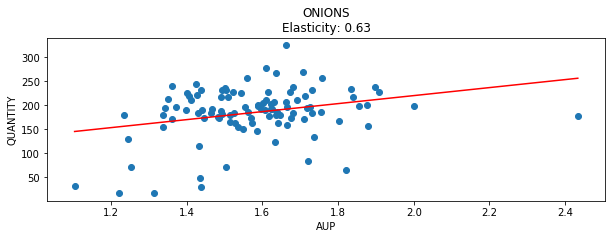

In [43]:
plot_price_and_quantity('ONIONS')

We can't have a very high confidence in the linear regressions because of the high frequency variation in the data.  
To try and fix this, we compute the average quantity purchased in each price bin and then try a linear regression. 
Moreover, we try and use a common, alternative formula for computing elasticities, which is called the midpoint formula, to reduce the variation in elasticiticies.

<img src="midpoint_method.jpeg" style="width: 350px;"/>

In [44]:
def midpoint_elasticity(q1,q2,p1,p2):
    percent_qty_change = (q2-q1)/((q1+q2)/2)
    percent_prc_change = (p2-p1)/((p1+p2)/2)
    return percent_qty_change/percent_prc_change

def bin_price_and_quantity(item):
    item_df = df_merged[df_merged.COMMODITY_DESC == item]
    y = item_df.groupby('AUP').agg('mean')['QUANTITY']
    x = y.index
    quantities_sum, bins = np.histogram(x, bins=10, weights=y)
    num_prices, _ = np.histogram(x, bins=10)
    
    # Remove empty bins
    zero_idx = np.argwhere(np.array(quantities_sum) == 0)
    zero_idx = zero_idx.reshape((zero_idx.size,))
    quantities_sum = np.delete(quantities_sum, zero_idx)
    num_prices = np.delete(num_prices, zero_idx)
    
    quantities = [s/t for s, t in zip(quantities_sum, num_prices)]
    prices = [(s+t)/2 for s, t in zip(bins[:-1], bins[1:])]
    prices = np.delete(prices, zero_idx)
    return prices, quantities

def plot_price_and_quantity_bin(item):
    prices, quantities = bin_price_and_quantity(item)
    
    plt.figure(figsize=(10, 3))
    plt.scatter(prices, quantities)
    plt.xlabel('AUP')
    plt.ylabel('QUANTITY')
    
    line_fit = np.polyfit(prices, quantities, 1)
    line = np.poly1d(line_fit)
    
    # Compute elasticity
    min_price = np.unique(prices).min()
    max_price = np.unique(prices).max()
    min_qty = line(min_price)
    max_qty = line(max_price)
    
    percent_price_increase = (max_price / min_price - 1) * 100
    elasticity = midpoint_elasticity(min_qty, max_qty, min_price, max_price)
    
    plt.title(item + '\nElasticity: ' + str(np.round(elasticity, 2)))
    plt.plot(np.unique(prices), line(np.unique(prices)), color='red')

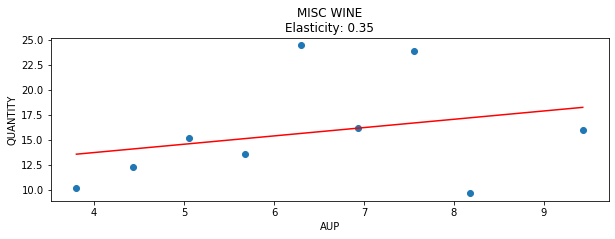

In [45]:
plot_price_and_quantity_bin('MISC WINE')

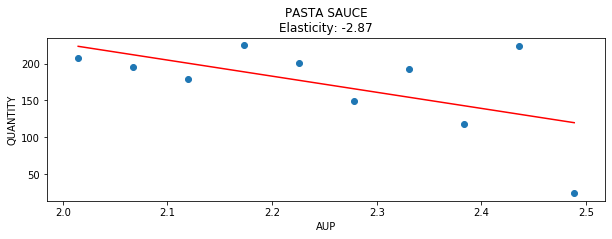

In [46]:
plot_price_and_quantity_bin('PASTA SAUCE')

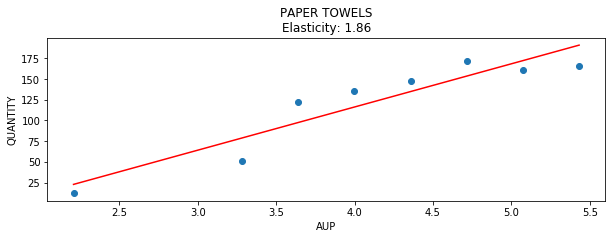

In [47]:
plot_price_and_quantity_bin('PAPER TOWELS')

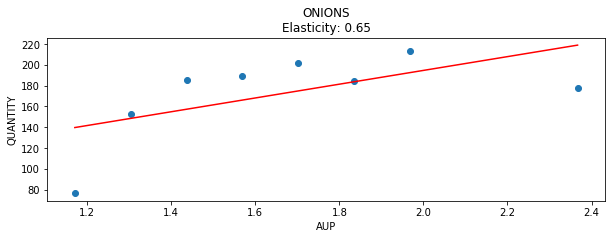

In [48]:
plot_price_and_quantity_bin('ONIONS')

The linear regression fit appears more reliable as mainly due to less variability of the observations within each product. Furthermore, the use of the midpoint formula helps avoid overstating the magnitudes of the elasticities.

Now we consider more seriously the limitations of our dataset. In practice, reliable computations of price elasticities require many observations gathered over several years, especially for rarely purchased items. Computations with limited data points are bound to give high varying -- and probably inaccurate -- results if the dataset spans a short time. For example, to evaluate the price elasticity of a tricycle or a barbeque grill from our dataset, which only has a few points over two years, is largely meaningless as we cannot be confident in its measure. In other words, our dataset only limits us to analyze items which are "common" or "somewhat common".

The notion of "common" is subject to personal interpretations, but we define it to be all items for which there are at least 27 observations in our datafarme (`df_merged`). This is because 27 observations imply that they had been purchased over a period of at least 6 months dispersed throughout the time span of our dataset (two years). Based on the second violinplot above, we still retain the majority of items in our dataset this way.

In [49]:
# Get items for which we have at least 27 observations
weekly_item_count = Counter(df_merged.COMMODITY_DESC)
common_goods = [x for x,c in weekly_item_count.items() if c >= 27]
print('Number of unique "common" items: ', len(common_goods))

# Filter dataframe on common goods
df_filtered = df_merged.copy()
for g in set(weekly_item_count.keys())-set(common_goods):
    df_filtered = df_filtered[df_filtered.COMMODITY_DESC != g]

print('Shape of filtered dataframe: ', df_filtered.shape)

Number of unique "common" items:  290
Shape of filtered dataframe:  (27282, 4)


In [50]:
# Compute elasticities of all products
elasticities = {}
for g in df_filtered.COMMODITY_DESC.unique():
    prcs, qtys = bin_price_and_quantity(g)
    
    # Fit linear regression
    line_fit = np.polyfit(prcs, qtys, 1)
    line = np.poly1d(line_fit)
    
    min_prc = np.unique(prcs).min()
    max_prc = np.unique(prcs).max()
    elasticities[g] = midpoint_elasticity(line(min_prc), line(max_prc), min_prc, max_prc)

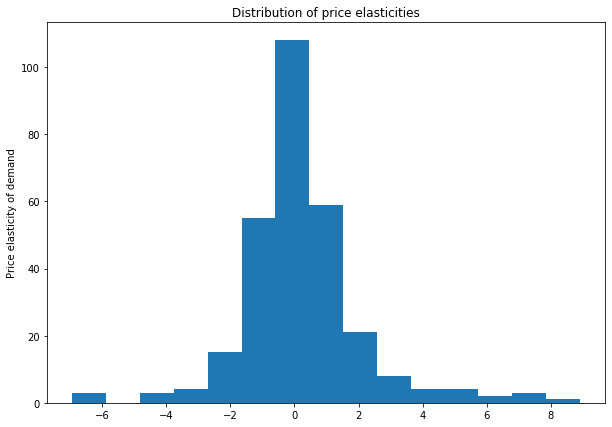

In [51]:
values = np.array([e for g,e in elasticities.items() if ~np.isnan(e)])
fig = plt.figure(figsize = (10,7))
plt.hist(values, bins = 15)
plt.ylabel('Price elasticity of demand')
plt.title('Distribution of price elasticities')
plt.show()

The majority of the products have elasticities close to 0. One striking observation of this distribution is that there are many products with positive elasticities. In principle, price elasticities of demand are always negative; this is because the law of demand states that when a good's price increases, its quantity demanded decreases. 

However, goods with positive elasticities do occur in real life and they are formally called the [Giffen products](https://www.investopedia.com/terms/g/giffen-good.asp). In reality, Giffen products are rare; however, given the limited time span of our dataset and the fact that our figures aren't economy-wide, this may be plausible. Giffen products tend to be low-budget, non-luxury goods with few available substitutes such as rice, potatos, wheat, soap, toilet paper, or even certain packaged meat items. 

Our guess is that if a product has a positive elasticity, then it is likely such a product.

In [52]:
# Get Giffen products (less than 1 can be argued to be non-significant i.e. inelastic)
giffen_products = [g for g,e in elasticities.items() if e > 1] 

# Concatenate product descriptions into one large string
document = ''
counter = 0
for g in giffen_products:
    counter += 1
    document += df_filtered[df_filtered.COMMODITY_DESC==g].COMMODITY_DESC.unique()[0].lower() + ' '

In [53]:
# Remove all special characters including punctuations
txt = re.sub('[^0-9a-zA-Z]', ' ', document)

# Remove reduncant spaces
txt = re.sub(' +', ' ', txt)

# Use gensim's simple preprocess to clean up further
txt = ' '.join(simple_preprocess(txt))

# Create a bigram model for better context
nltk.download('punkt')
bigram = gensim.models.Phrases(txt, min_count=1, threshold=1)
bigram_mod = gensim.models.phrases.Phraser(bigram)
txt = ' '.join(bigram_mod[word_tokenize(txt)])

# Lemmatize
# You have to execute "python -m spacy download en_core_web_lg" in a shell to be able to load it
nlp = spacy.load('en_core_web_sm')
doc = nlp(txt)
txt = [token.lemma_ for token in doc]

# Remove some custom stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['all','non','food','other','cold','hot','misc','product','care'])
txt = [t for t in txt if t not in stop_words]

[nltk_data] Downloading package punkt to /home/frederic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/frederic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total number of unique terms:  105


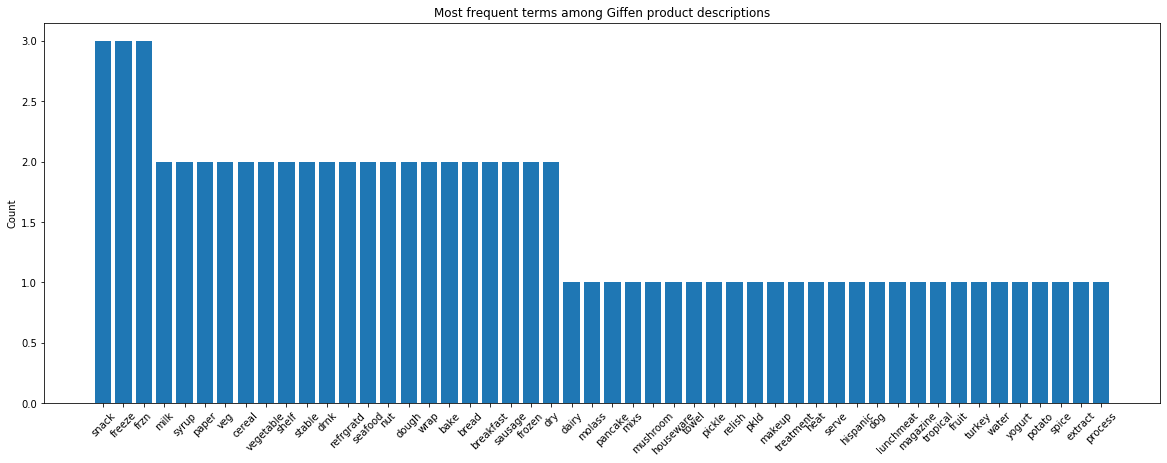

In [54]:
print('Total number of unique terms: ', len(set(txt)))
tf = Counter(txt).most_common(50)
xaxis = [g for g,x in tf]
yaxis = [x for g,x, in tf]

fig, ax = plt.subplots(figsize=(20,7))
ax.bar(np.arange(1,len(yaxis)+1,1), yaxis)
ax.set_xticks(np.arange(1,len(yaxis)+1,1))
ax.set_xticklabels(xaxis, rotation=45)
ax.set_title('Most frequent terms among Giffen product descriptions')
ax.set_ylabel('Count')
plt.show()

Indeed, we can notice that the products with positive elasticities (aka. Giffen products) are typically low-budget, non-luxury items. In the top rankings, we see the term "frozen" and "frzn", most probably alluding to frozen food packages that are generally cheap. We also see many indications "bread" (dough, bake, bread, etc.) in accordance with our initial guess. There are also many indications of dairy products in this ranking, which are likewise non-luxury, essential goods. 

In principle, price elasticity should be negative. But in reality, this may not always be the case since there are too many effects that have an influence. Another thing we can try is to use the total expenditure (equal to quantity * aup) instead of quantity alone. This may give less volatile results.

In [55]:
def plot_price_and_expenditure_bin(item):
    item_df = df_merged[df_merged.COMMODITY_DESC == item].copy()
    item_df['EXPENDITURE'] = item_df.QUANTITY * item_df.AUP
    
    y = item_df.groupby('AUP').agg('sum')['EXPENDITURE']
    x = y.index
    quantities_sum, bins = np.histogram(x, bins=10, weights=y)
    num_prices, _ = np.histogram(x, bins=10)
    
    # Remove empty bins
    zero_idx = np.argwhere(np.array(quantities_sum) == 0)
    zero_idx = zero_idx.reshape((zero_idx.size,))
    quantities_sum = np.delete(quantities_sum, zero_idx)
    num_prices = np.delete(num_prices, zero_idx)
    
    quantities = [s/t for s, t in zip(quantities_sum, num_prices)]
    prices = [(s+t)/2 for s, t in zip(bins[:-1], bins[1:])]
    prices = np.delete(prices, zero_idx)
    
    plt.figure(figsize=(10, 3))
    plt.scatter(prices, quantities)
    plt.xlabel('AUP')
    plt.ylabel('TOTAL EXPENDITURE')
    
    line_fit = np.polyfit(prices, quantities, 1)
    line = np.poly1d(line_fit)
    
    # Compute elasticity
    min_price = np.unique(prices).min()
    max_price = np.unique(prices).max()
    min_qty = line(min_price)
    max_qty = line(max_price)
    
    percent_price_increase = (max_price / min_price - 1) * 100
    elasticity = (max_qty / min_qty - 1) * 100 / percent_price_increase
    
    plt.title(item + '\nExpenditure: ' + str(np.round(elasticity, 2)))
    
    plt.plot(np.unique(prices), line(np.unique(prices)), color='red')

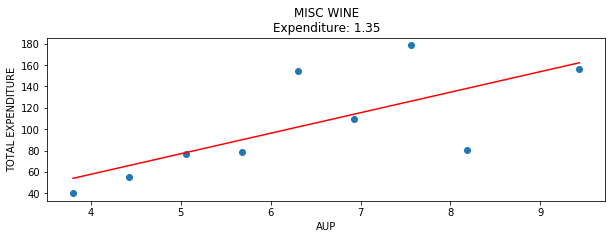

In [56]:
plot_price_and_expenditure_bin('MISC WINE')

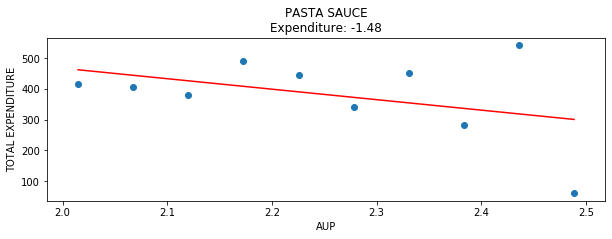

In [57]:
plot_price_and_expenditure_bin('PASTA SAUCE')

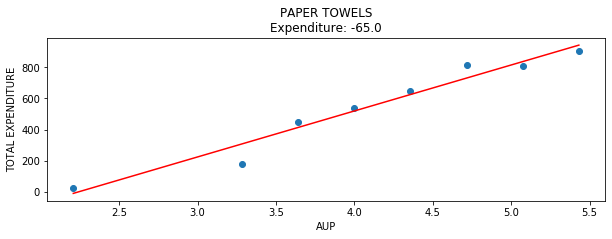

In [58]:
plot_price_and_expenditure_bin('PAPER TOWELS')

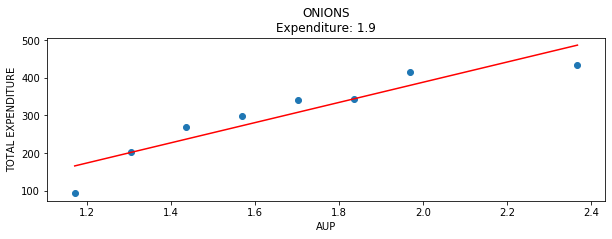

In [59]:
plot_price_and_expenditure_bin('ONIONS')

Finally, one last thing to try is to use linear regression on historical data, that is evolution of expenditure along time stamps. That might be interesting to quantitfy sells of a product while taking into account the date. However, we should keep in mind that we only have data over two years that is sparse for a lot of "uncommon" products, and that might influence results in a bad manner (divergence from expectations).

In [60]:
from sklearn.linear_model import LinearRegression

def plot_expenditure_over_time(item):
    item_df = df_merged[df_merged.COMMODITY_DESC == item].copy()
    item_df['EXPENDITURE'] = item_df.QUANTITY * item_df.AUP
    
    X = item_df['WEEK_NO'].values.reshape(-1, 1)
    Y = item_df['EXPENDITURE'].values.reshape(-1, 1)

    plt.plot(X, Y)
    
    lin_reg = LinearRegression()
    lin_reg.fit(X, Y)
    Y_pred = lin_reg.predict(X)
    
    # Compute elasticity
    min_price = np.unique(Y_pred).min()
    max_price = np.unique(Y_pred).max()
    
    # len(X) does represent the number of weeks with values for this item
    percent_price_increase = (max_price / min_price - 1) * 100
    elasticity = len(X) / percent_price_increase
    
    plt.title(item + '\nExpenditure over time: ' + str(np.round(elasticity, 2)))
    plt.plot(X, Y_pred, color='red')

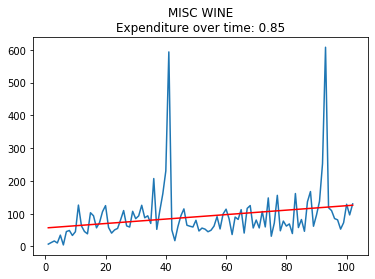

In [61]:
plot_expenditure_over_time('MISC WINE')

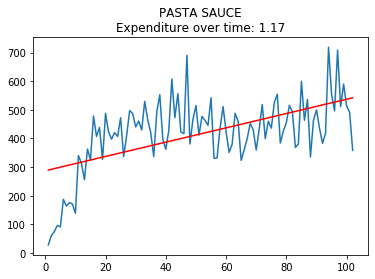

In [62]:
plot_expenditure_over_time('PASTA SAUCE')

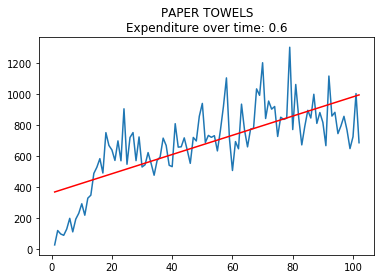

In [63]:
plot_expenditure_over_time('PAPER TOWELS')

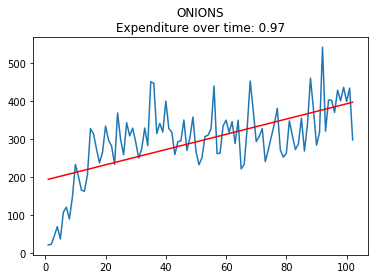

In [64]:
plot_expenditure_over_time('ONIONS')

### C) Measuring complementarity between products
Price elasticity of demand looks at each product independently. However, two products' relationship (either complementary or substitutable) can be computed using the *cross price elasticity of demand*. Given products A and B, it describes the percent change in the quantity demanded of product A upon 1% change in the price of product B, and vice versa. This work will become the ground for our main result, which is the visualization of product relationships in a network.

Our main steps are as follows:
1. Join two items by weeks so as to compare their price and quantity changes over the same time frame.
2. Plot one item's prices vs. the other's quantities (and vice versa) and perform linear regression using the "binning" approach as before to redue variability within data.
3. Obtain the cross elasticity from the slope of the linear regression fit, again using the midpoint formula for elasticity.

In [65]:
def bin_price_and_quantity_two_products(items):
    # Price of item 1 on item 2's quantities and vice versa
    y1 = items.groupby('AUP_1').agg('mean')['QUANTITY_2']
    y2 = items.groupby('AUP_2').agg('mean')['QUANTITY_1']
    
    x1 = y1.index
    x2 = y2.index
    
    qty_sum1, bins1 = np.histogram(x1, bins = 10, weights = y1)
    qty_sum2, bins2 = np.histogram(x2, bins = 10, weights = y2)
    
    # Binning
    num_prices1, _ = np.histogram(x1, bins = 10)
    num_prices2, _ = np.histogram(x2, bins = 10)
    
    # Remove empty bins
    zero_idx1 = np.argwhere(np.array(qty_sum1) == 0)
    zero_idx1 = zero_idx1.reshape((zero_idx1.size,))
    zero_idx2 = np.argwhere(np.array(qty_sum2) == 0)
    zero_idx2 = zero_idx2.reshape((zero_idx2.size,))
    qty_sum1 = np.delete(qty_sum1, zero_idx1)
    qty_sum2 = np.delete(qty_sum2, zero_idx2)
    num_prices1 = np.delete(num_prices1, zero_idx1)
    num_prices2 = np.delete(num_prices2, zero_idx2)
    
    qtys1 = [s/t for s, t in zip(qty_sum1, num_prices1)]
    prices1 = [(s+t)/2 for s, t in zip(bins1[:-1], bins1[1:])]
    prices1 = np.delete(prices1, zero_idx1)
    
    qtys2 = [s/t for s, t in zip(qty_sum2, num_prices2)]
    prices2 = [(s+t)/2 for s, t in zip(bins2[:-1], bins2[1:])]
    prices2 = np.delete(prices2, zero_idx2)
    return qtys1, qtys2, prices1, prices2

def plot_price_and_quantity_bin_two_products(items, plot = 1):
    qtys1, qtys2, prcs1, prcs2 = bin_price_and_quantity_two_products(items)
    
    if plot:
        plt.figure(figsize = (10, 3))
        plt.scatter(prcs1, qtys1)
        plt.xlabel('AUP')
        plt.ylabel('QUANTITY')

    # Two regressions
    line_fit1 = np.polyfit(prcs1, qtys1, 1)
    line1 = np.poly1d(line_fit1)
    line_fit2 = np.polyfit(prcs2, qtys2, 1)
    line2 = np.poly1d(line_fit2)
    
    # Compute elasticity
    min_price1 = np.unique(prcs1).min()
    max_price1 = np.unique(prcs1).max()
    min_qty1 = line1(min_price1)
    max_qty1 = line1(max_price1)
    min_price2 = np.unique(prcs2).min()
    max_price2 = np.unique(prcs2).max()
    min_qty2 = line2(min_price2)
    max_qty2 = line2(max_price2)
    
    cross_elasticity1 = midpoint_elasticity(max_qty1, min_qty1, max_price1, min_price1)
    cross_elasticity2 = midpoint_elasticity(max_qty2, min_qty2, max_price2, min_price2)
    
    # Cross elasticity is the average
    cross_elasticity = (cross_elasticity1 + cross_elasticity2)/2
    
    if plot:
        plt.title(items.COMMODITY_DESC_1.unique()[0] +' and ' \
                  + items.COMMODITY_DESC_2.unique()[0] + '\nCross Elasticity: ' \
                  + str(np.round(cross_elasticity, 2)))
        plt.plot(np.unique(prcs1), line1(np.unique(prcs1)), color='red')
    return cross_elasticity

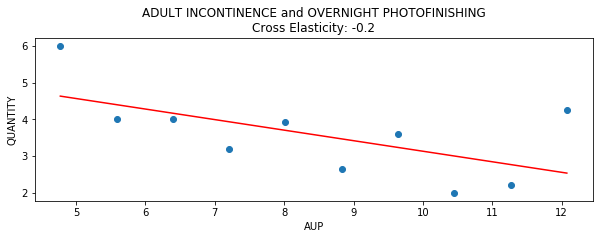

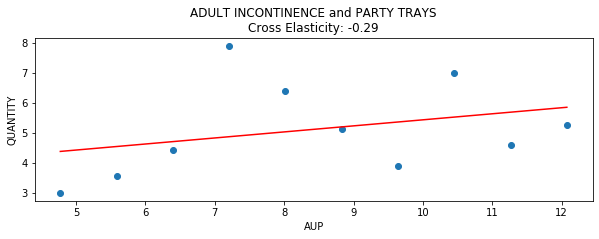

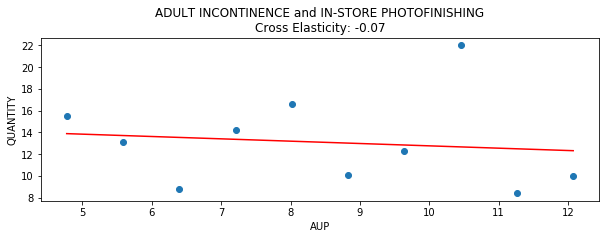

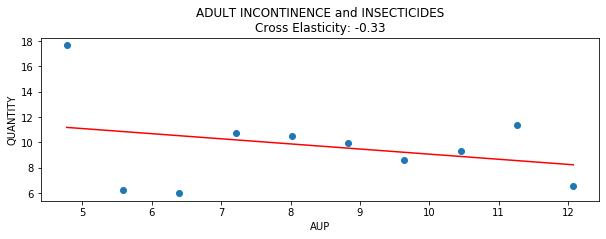

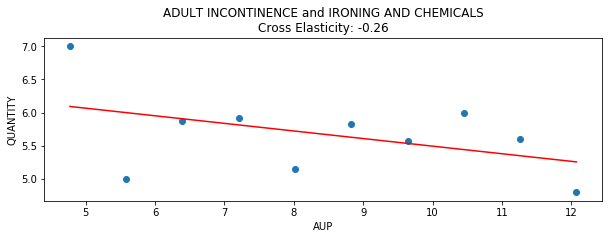

In [66]:
# Form every pair of products
pairs = itertools.combinations(list(df_filtered.COMMODITY_DESC.unique()), 2)

# Experiment with a few pairs
for pair in list(pairs)[200:205]:
    item1_df = df_filtered[df_filtered.COMMODITY_DESC == pair[0]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    item2_df = df_filtered[df_filtered.COMMODITY_DESC == pair[1]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    
    # Join by week number -- make sure that we observe along the same time frame
    joined_df = item1_df.join(item2_df, how = 'inner', lsuffix = '_1', rsuffix = '_2')
    joined_df.sort_index(inplace = True)
    
    if joined_df.shape[0] <= 1:
        continue # Need more than one overlapping time indices to compute elasticity!
    
    plot_price_and_quantity_bin_two_products(joined_df)

In the above, we show the cross elasticity example with adult incontinence product -- which is very particular -- with five other products. We expect the first item to be largely independent on any other product's prices, which we can verify to some extent above. The magnitude of the cross elasticities is less than 1, which suggests that adult incontinence is *inelastic* to price changes in the other goods.

In [67]:
# First, collect all pairwise cross elasticities
pairs = itertools.combinations(list(df_filtered.COMMODITY_DESC.unique()), 2)
cross_elasticities = {}
for pair in list(pairs):
    item1_df = df_filtered[df_filtered.COMMODITY_DESC == pair[0]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    item2_df = df_filtered[df_filtered.COMMODITY_DESC == pair[1]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    
    # Join by week number 
    joined_df = item1_df.join(item2_df, how = 'inner', lsuffix = '_1', rsuffix = '_2')
    joined_df.sort_index(inplace=True)
    
    if joined_df.shape[0] <= 1:
        continue 
    ce = plot_price_and_quantity_bin_two_products(joined_df, plot = 0)
    
    # Update dictionary
    cross_elasticities[(joined_df.COMMODITY_DESC_1.unique()[0], joined_df.COMMODITY_DESC_2.unique()[0])] = ce

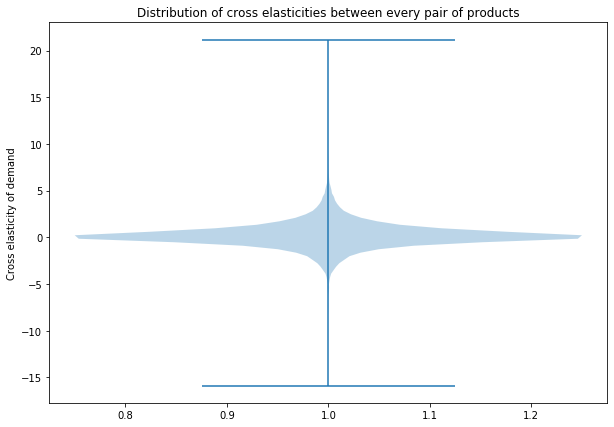

In [68]:
# Verify that cross elasticities are mostly positive
vals = [y for x,y in cross_elasticities.items()]
fig = plt.figure(figsize = (10,7))
plt.violinplot(vals)
plt.title('Distribution of cross elasticities between every pair of products')
plt.ylabel('Cross elasticity of demand')
plt.show()

### D) Effect of income and presence of children on food purchases
Given householders set, we might want to study how purchases vary along some parameters, and see if there are correlations between these pairs. An additional idea is to represent householders as nodes (size of node being proportional to income), put jaccard similarities between sets of bought products as edges, and then see if we can form clusters and figure out that some products or sets of products are related to a certain type of revenue.

First, we modify the household dataframe to include only relevant information.

In [69]:
# Look at the possible values for the household income
hh_demographic['INCOME_DESC'].unique()

array(['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
       '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K'],
      dtype=object)

In [70]:
def parse_income(income):
    if '-' in income:
        # take the average of the bounds
        bounds = income.split('-')
        res = (int(bounds[0]) + int(bounds[1][:-1])) / 2
    elif '+' in income:
        # if it's 250K+ assume it's 250K
        res = int(income.split('+')[0][:-1])
    else:
        res = int(income.split(' ')[-1][:-1])
    return 1000 * res

hh_demographic['income'] = hh_demographic.apply(lambda row: parse_income(row['INCOME_DESC']), axis=1)

In [71]:
# Look at the possible values for the household composition
hh_demographic['HH_COMP_DESC'].unique()

array(['2 Adults No Kids', '2 Adults Kids', 'Single Female', 'Unknown',
       'Single Male', '1 Adult Kids'], dtype=object)

In [72]:
# Look at the possible values for the household size
hh_demographic['HOUSEHOLD_SIZE_DESC'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

In [73]:
# Look at the possible values for the household children
hh_demographic['KID_CATEGORY_DESC'].unique()

array(['None/Unknown', '1', '2', '3+'], dtype=object)

In [74]:
def parse_children(composition, hh_size, kids):
    tot_size = int(hh_size.split('+')[0])
    
    if 'Single' in composition or '1' in composition:
        nb_adults = 1
    elif '2' in composition:
        nb_adults = 2
    else:
        # assume it's 2 adults by default and correct later if contradictory data
        nb_adults = 2
    
    if kids == 'None/Unknown':
        # assume it's 0 kids by default and correct later if contradictory data
        nb_kids = 0
    else:
        nb_kids = int(kids.split('+')[0])
    
    if nb_kids + nb_adults == tot_size:
        nb_children = nb_kids
    elif nb_kids + nb_adults > tot_size:
        # We have overestimated the number of adults
        nb_children = nb_kids
    else:
        # We have underestimated the number of kids
        nb_children = tot_size - nb_adults
    return nb_children

hh_demographic['children'] = hh_demographic.apply(
    lambda row: parse_children(
        row['HH_COMP_DESC'], 
        row['HOUSEHOLD_SIZE_DESC'], 
        row['KID_CATEGORY_DESC']
    ), 
    axis=1
)

In [75]:
# Created a new dataframe with the relevent information, i.e. household_key, income and number of children
household_df = hh_demographic[['household_key', 'income', 'children']]
household_df.head()

,household_key,income,children
0,1,42000.0,0
1,7,62000.0,0
2,8,29500.0,1
3,13,87000.0,2
4,16,62000.0,0


Now we group the transactions by product and household.

In [76]:
transaction_data_hh.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,AUP
11,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19
12,1364,26984896261,1,897044,1,2.99,31742,-0.40,1520,1,0.0,0.0,3.39
13,1364,26984896261,1,920955,1,3.09,31742,0.00,1520,1,0.0,0.0,3.09
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,3.49
15,1364,26984896261,1,981760,1,0.60,31742,-0.79,1520,1,0.0,0.0,1.39


In [77]:
# First filter columns we don't need
filtered_trans_hh = transaction_data_hh[['household_key','PRODUCT_ID','SALES_VALUE']].copy()

# Compute total expenditure per product per household
total_expenditure = filtered_trans_hh.groupby(['household_key', 'PRODUCT_ID']).agg('sum')['SALES_VALUE']

df = total_expenditure.reset_index() # Unravels the multiindex into columns
df = df.sort_values(by = 'household_key', axis = 0).reset_index(drop = True) # Sort by household
df.head()

,household_key,PRODUCT_ID,SALES_VALUE
0,1,819312,5.67
1,1,1111870,7.72
2,1,1112333,0.46
3,1,1113385,2.17
4,1,1115576,6.50


In [78]:
# Join df with product to get commodity descriptions
df_merged_hh = df.join(product.set_index('PRODUCT_ID'), on='PRODUCT_ID', how='left')
df_merged_hh.head()

,household_key,PRODUCT_ID,SALES_VALUE,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,1,819312,5.67,3262,DRUG GM,National,IN-STORE PHOTOFINISHING,ONE HOUR PROCESSING,
1,1,1111870,7.72,1266,GROCERY,National,PNT BTR/JELLY/JAMS,PRESERVES JAM MARMALADE,18 OZ
2,1,1112333,0.46,2,PRODUCE,National,VEGETABLES - ALL OTHERS,GREENS,25 LB
3,1,1113385,2.17,693,DRUG GM,National,CANDY - PACKAGED,SEASONAL CANDY BAGS-CHOCOLATE,13 OZ
4,1,1115576,6.50,1183,GROCERY,National,BAKED BREAD/BUNS/ROLLS,ENGLISH MUFFINS/WAFFLES,12 OZ


In [79]:
# Again aggregate expenditures
tot_expenditure_hh = df_merged_hh.groupby(['household_key','COMMODITY_DESC']).agg('sum')['SALES_VALUE']

df_merged_hh = tot_expenditure_hh.reset_index()   # Unravels the multiindex into columns
df_merged_hh = df_merged_hh[df_merged_hh['COMMODITY_DESC']!='NO COMMODITY DESCRIPTION']
df_merged_hh = df_merged_hh.sort_values(by='household_key', axis=0).reset_index(drop=True) # Sort by household
df_merged_hh.head()

,household_key,COMMODITY_DESC,SALES_VALUE
0,1,AIR CARE,57.66
1,1,PORK,4.45
2,1,POPCORN,2.00
3,1,PNT BTR/JELLY/JAMS,52.67
4,1,PIES,22.94


In [80]:
# Now, let's compute the average weekly spending for each household on each product
transaction_weeks = transaction_data_hh[['household_key', 'WEEK_NO']]
num_weeks_per_household = transaction_weeks.groupby(['household_key']).WEEK_NO.nunique()

# Merge with number of weeks the household participated in
df_merged_hh = df_merged_hh.join(num_weeks_per_household, on='household_key', how='left')
df_merged_hh['weekly_expenditure'] = df_merged_hh.apply(lambda row: row['SALES_VALUE'] / row['WEEK_NO'], axis = 1)

# Keep only relevant info
df_merged_hh = df_merged_hh[['household_key', 'COMMODITY_DESC', 'weekly_expenditure']]
df_merged_hh.head()

,household_key,COMMODITY_DESC,weekly_expenditure
0,1,AIR CARE,0.847941
1,1,PORK,0.065441
2,1,POPCORN,0.029412
3,1,PNT BTR/JELLY/JAMS,0.774559
4,1,PIES,0.337353


In [81]:
# Helper function to convert data to dict for each household
def household_dict(household_key):
    df = df_merged_hh[df_merged_hh['household_key']==household_key]
    return df.set_index('COMMODITY_DESC').to_dict()['weekly_expenditure']

# Compute the size of the intersection of the two dicts, 
# weighted by the ratio between the lowest and highest expenditure for each product
def intersect_dicts(dict1, dict2):
    keys = set(dict1.keys()) & set(dict2.keys())
    intersection_score = 0
    for key in keys:
        intersection_score += min(dict1[key], dict2[key]) / max(dict1[key], dict2[key])
    return intersection_score

# Compute the size of the union of the two dicts
def union_dicts(dict1, dict2):
    keys = set(dict1.keys()) | set(dict2.keys())
    union_score = len(keys)
    return union_score

# Compute the Jaccard similarity where the intersection is weighted 
# by the difference in expenditure for each product
def similarity(dict1, dict2):
    return intersect_dicts(dict1, dict2) / union_dicts(dict1, dict2)

In [82]:
# Convert each household to a dict
household_dicts = {}
for key in household_df['household_key']:
    household_dicts[key] = household_dict(key)

In [83]:
# Create a similarity dict with an entry for each pair of households
hh_similarity_dict = {}

for pair in itertools.combinations(list(household_df['household_key']), 2):
    hh_similarity_dict[pair] = similarity(household_dicts[pair[0]], household_dicts[pair[1]])

In [84]:
# Let's look at some numbers
print(
    'min value: ' + str(min(hh_similarity_dict.values())), 
    'max value: ' + str(max(hh_similarity_dict.values()))
)
cutoff = 0.2
print(
    str(np.round(
        100*np.sum(np.array(list(hh_similarity_dict.values())) > cutoff) / len(hh_similarity_dict), 1
    )) + '% above cutoff of ' + str(cutoff))

min value: 0.03211189149417313 max value: 0.42319154522069286
63.8% above cutoff of 0.2


We can see that 46.9% of pairs of households a similarity value greate than 0.2.

In [85]:
# Get the 10000 pairs of households with the highest similarity of expenditure
k = 10000
top_pairs = heapq.nlargest(k, hh_similarity_dict, key=hh_similarity_dict.get)

hh_df = household_df.set_index('household_key')

# Let's see how many of them have households in the same income range, with the same number of children and both
nb_same_income = 0
nb_same_children = 0
nb_same_both = 0
for pair in top_pairs:
    hh1 = hh_df.loc[pair[0]]
    hh2 = hh_df.loc[pair[1]]
    
    if hh1.income == hh2.income:
        nb_same_income += 1
    
    if hh1.children == hh2.children:
        nb_same_children += 1
    
    if hh1.income == hh2.income and hh1.children == hh2.children:
        nb_same_both += 1

print('Of the 10,000 most similar households in terms of purchases:')
print(str(np.round(100 * nb_same_income / k, 1)) + '% are in the same income range.')
print(str(np.round(100 * nb_same_children / k, 1)) + '% have the same number of children.')
print(str(np.round(100 * nb_same_both / k, 1)) + '% are in the same income range and have the same number of children.')

Of the 10,000 most similar households in terms of purchases:
17.0% are in the same income range.
40.5% have the same number of children.
7.8% are in the same income range and have the same number of children.


In [86]:
expected_same_income_range_if_no_correlation = np.round(
    100*len(household_df.income.unique()) / sum(range(len(household_df.income.unique()) + 1)), 
    1
)
expected_same_children_if_no_correlation = np.round(
    100*len(household_df.children.unique()) / sum(range(len(household_df.children.unique()) + 1)), 
    1
)
expected_same_both_if_no_correlation = np.round(
    100*(len(household_df.income.unique()) + len(household_df.children.unique())) /
    sum(range(len(household_df.income.unique()) + len(household_df.children.unique()) + 1)), 
    1
)

print('If there is no correlation:')
print(str(expected_same_income_range_if_no_correlation) + '% are expected to be in the same income range.')
print(str(expected_same_children_if_no_correlation) + '% are expected to have the same number of children.')
print(str(expected_same_both_if_no_correlation) + 
      '% are expected to be in the same income range and have the same number of children.')

If there is no correlation:
15.4% are expected to be in the same income range.
33.3% are expected to have the same number of children.
11.1% are expected to be in the same income range and have the same number of children.


We can see that we roughly get the numbers we expect if there was no correlation between the income range, number of chidren and purchases of children.

A possible explanation is that there are only a few products related with the household income range and number of children.  
Another is that the products related to those factors were purchased in other (perhaps specialized in luxury items / items related to children) stores not included in this dataset.

### Try to find products related to income / children

In [87]:
# Create a dict from household key to income bracket and one from income bracket to number
# of households in that income bracket
key_to_income = {}
num_hh_per_income = {}
for income_bracket in household_df.income.unique():
    household_keys = household_df[household_df.income == income_bracket].household_key
    num_hh_per_income[income_bracket] = household_keys.size
    for household_key in household_keys:
        key_to_income[household_key] = income_bracket

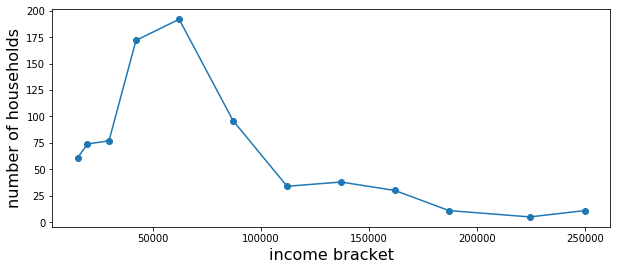

In [88]:
# Plot the number of households per income bracket
x, y = zip(*sorted(num_hh_per_income.items()))
plt.figure(figsize=(10, 4))
plt.plot(x, y, marker='o')
plt.xlabel('income bracket', fontsize=16)
plt.ylabel('number of households', fontsize=16)
plt.show()

The last 3 income brackets don't have many households: let's group them together.

In [89]:
# Compute new bracket
brackets_to_group = sorted(num_hh_per_income)[-3:]
num_grouped_hh = np.sum([num_hh_per_income[x] for x in brackets_to_group])
new_bracket = np.round(np.sum([x * num_hh_per_income[x] for x in brackets_to_group]) / \
                num_grouped_hh)

# Update dictionnaries
for k, v in key_to_income.items():
    if v in brackets_to_group:
        key_to_income[k] = new_bracket

for bracket in brackets_to_group:
    del num_hh_per_income[bracket]

num_hh_per_income[new_bracket] = num_grouped_hh

In [90]:
# Create a dataframe of average weekly expenditure per product in an income bracket
df_merged_by_income = df_merged_hh.copy()
df_merged_by_income['income_bracket'] = df_merged_by_income['household_key'].map(lambda x: key_to_income[x])
df_merged_by_income.drop(['household_key'], axis=1, inplace=True)
# We compute the sum and then divide by the number of households in the income bracket because the 'mean' 
# would not count households which haven't purchased that product in the mean
df_merged_by_income = df_merged_by_income.groupby(['income_bracket','COMMODITY_DESC']).agg('sum').reset_index()
df_merged_by_income['weekly_expenditure'] = df_merged_by_income.apply(
    lambda row: row.weekly_expenditure / num_hh_per_income[row.income_bracket], 
    axis=1
)
df_merged_by_income.head()

,income_bracket,COMMODITY_DESC,weekly_expenditure
0,15000.0,(CORP USE ONLY),0.001187
1,15000.0,ADULT INCONTINENCE,0.020611
2,15000.0,AIR CARE,0.116149
3,15000.0,ANALGESICS,0.114462
4,15000.0,ANTACIDS,0.064066


In [91]:
def plot_income_corr(products, title=True):
    if not type(products) is list:
        products = [products]
    table = df_merged_by_income[df_merged_by_income.COMMODITY_DESC.isin(products)]
    table = table.groupby(['income_bracket']).agg('sum').reset_index()
    income = table['income_bracket']
    expenditure = table['weekly_expenditure']
    plt.figure(figsize=(10, 2))
    plt.plot(income, expenditure, marker='o')
    if title:
        plt.title('Correlation of ' + ', '.join(products) + ' with income', fontsize=18)
    plt.xlabel('Household income', fontsize=16)
    plt.ylabel('Weekly expenditure', fontsize=16)
    plt.show()

In [92]:
def product_income_corr(products):
    if not type(products) is list:
        products = [products]
    table = df_merged_by_income[df_merged_by_income.COMMODITY_DESC.isin(products)]
    table = table.groupby(['income_bracket']).agg('sum').reset_index()
    income = table['income_bracket']
    expenditure = table['weekly_expenditure']
    if len(income) > 2:
        return scipy.stats.pearsonr(income, expenditure)
    else:
        # If there are only 2 brackets with data we don't do anything with the results
        return (0.0, 1.0)

Now let's compute the same things for children correlation.

In [93]:
# Create a dict from household key to number of children and one from number of children to number
# of households in that bracket
key_to_children = {}
num_hh_per_children = {}
for children in household_df.children.unique():
    household_keys = household_df[household_df.children == children].household_key
    num_hh_per_children[children] = household_keys.size
    for household_key in household_keys:
        key_to_children[household_key] = children

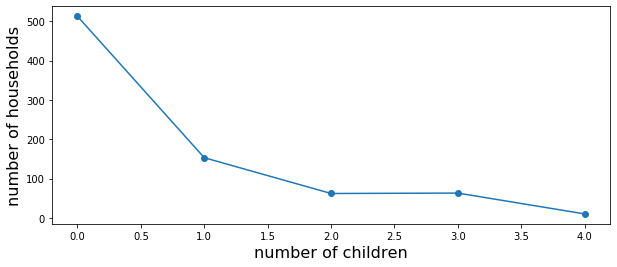

In [94]:
# Plot the number of households per number of children
x, y = zip(*sorted(num_hh_per_children.items()))
plt.figure(figsize=(10, 4))
plt.plot(x, y, marker='o')
plt.xlabel('number of children', fontsize=16)
plt.ylabel('number of households', fontsize=16)
plt.show()

Not many households have 4 children. Let's group them with households with 3 children

In [95]:
# We set each household which has 4 children as if they had only 3
for k, v in key_to_children.items():
    if v == 4:
        key_to_children[k] = 3

num_hh_per_children[3] += num_hh_per_children[4]
del num_hh_per_children[4]

In [96]:
# Create a dataframe of average weekly expenditure per product in an income bracket
df_merged_by_children = df_merged_hh.copy()
df_merged_by_children['children'] = df_merged_by_children['household_key'].map(lambda x: key_to_children[x])
df_merged_by_children.drop(['household_key'], axis=1, inplace=True)
# We compute the sum and then divide by the number of households in the income bracket because the 'mean' 
# would not count households which haven't purchased that product in the mean
df_merged_by_children = df_merged_by_children.groupby(['children','COMMODITY_DESC']).agg('sum').reset_index()
df_merged_by_children['weekly_expenditure'] = df_merged_by_children.apply(
    lambda row: row.weekly_expenditure / num_hh_per_children[row.children], 
    axis=1
)
df_merged_by_children.head()

,children,COMMODITY_DESC,weekly_expenditure
0,0,(CORP USE ONLY),0.002635
1,0,ADULT INCONTINENCE,0.062552
2,0,AIR CARE,0.185153
3,0,ANALGESICS,0.218091
4,0,ANTACIDS,0.100869


In [97]:
def plot_children_corr(products, title=True):
    if not type(products) is list:
        products = [products]
    table = df_merged_by_children[df_merged_by_children.COMMODITY_DESC.isin(products)]
    table = table.groupby(['children']).agg('sum').reset_index()
    children = table['children']
    expenditure = table['weekly_expenditure']
    plt.figure(figsize=(10, 2))
    plt.plot(children, expenditure, marker='o')
    if title:
        plt.title('Correlation of ' + ', '.join(products) + ' with children', fontsize=18)
    plt.xlabel('Household children', fontsize=16)
    plt.ylabel('Weekly expenditure', fontsize=16)
    plt.show()

In [98]:
def product_children_corr(products):
    if not type(products) is list:
        products = [products]
    table = df_merged_by_children[df_merged_by_children.COMMODITY_DESC.isin(products)]
    table = table.groupby(['children']).agg('sum').reset_index()
    children = table['children']
    expenditure = table['weekly_expenditure']
    if len(children) > 2:
        return scipy.stats.pearsonr(children, expenditure)
    else:
        # If there are only 2 brackets with data we don't do anything with the results
        return (0.0, 1.0)

In [99]:
# Create a dict a products to correlations
products_income_corr = {}
products_children_corr = {}

# We only keep correlations with have a p-value <= 0.015
p_value_cutoff = 0.5

products = df_merged_hh.COMMODITY_DESC.unique()
for product in products:
    income_corr, income_p_value = product_income_corr(product)
    children_corr, children_p_value = product_children_corr(product)
    
    if income_p_value <= p_value_cutoff:
        products_income_corr[product] = income_corr
    if children_p_value <= p_value_cutoff:
        products_children_corr[product] = children_corr

In [100]:
def top_k_corr(k=5, type='income', corr='positive'):
    if type == 'income':
        items = sorted(products_income_corr, key=products_income_corr.get)
    else:
        items = sorted(products_children_corr, key=products_children_corr.get)
    
    if corr == 'positive':
        items = items[-k:]
    else:
        items = items[:k]
    
    return items

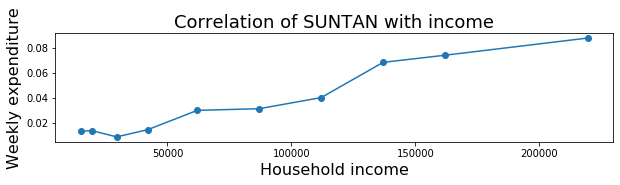

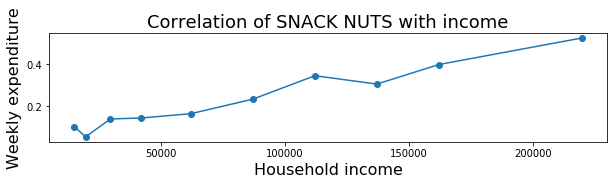

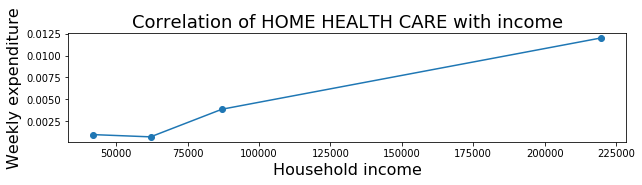

In [101]:
# Display the 3 products most correlated with income
most_income_corr = top_k_corr(k=3)
for x in most_income_corr:
    plot_income_corr(x)

Products such as suntan (which is a skin tanning product) and home health care are luxury products and are expected to correlate with income. Snack nuts are a bit more surprising but the fact that they are usually more expensive than other snacks might explain this.

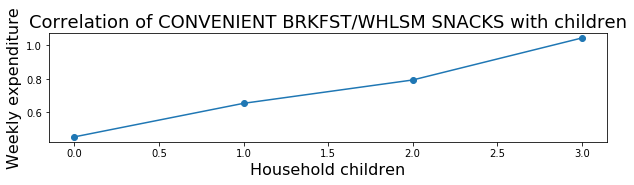

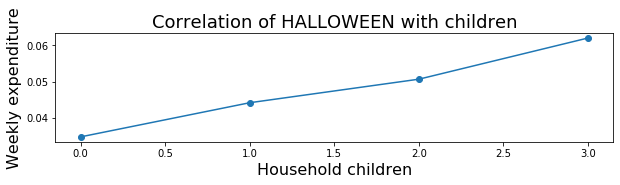

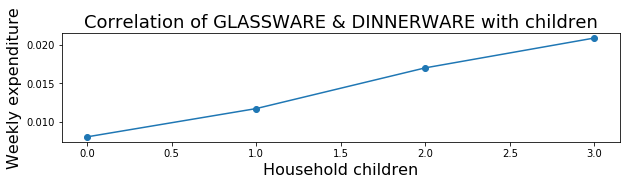

In [102]:
# Display the 3 products most correlated with children
most_children_corr = top_k_corr(k=3, type='children')
for x in most_children_corr:
    plot_children_corr(x)

It seems logical that halloween and glassware/dinnerware are correlated with children.

In [103]:
# Let's get the 5 least/most correlated products with income/children
income_products = top_k_corr(k=5, type='income', corr='positive')
income_products.extend(top_k_corr(k=5, type='income', corr='negative'))

children_products = top_k_corr(k=5, type='children', corr='positive')
children_products.extend(top_k_corr(k=5, type='children', corr='negative'))

names = list(set(income_products) | set(children_products))
i_corr = [products_income_corr[x] if x in products_income_corr else 0.0 for x in names]
c_corr = [products_children_corr[x] if x in products_children_corr else 0.0 for x in names]

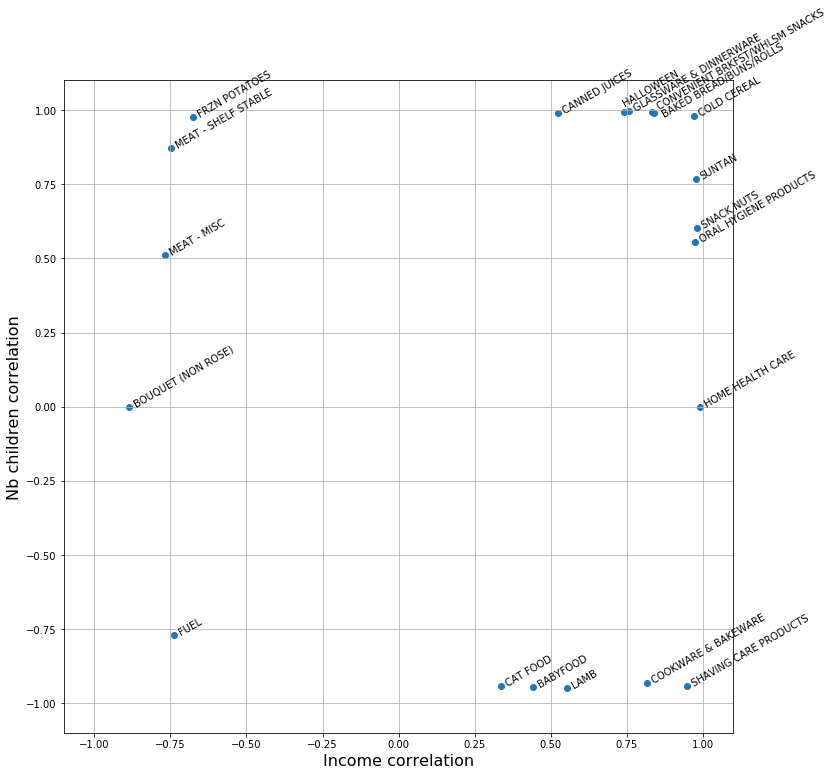

In [104]:
# Display those products
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(i_corr, c_corr)

for i, name in enumerate(names):
    x_alignement = 0
    y_alignement = 0
    if name ==  'HALLOWEEN':
        x_alignement = -0.02
        y_alignement = 0.02
    elif name == 'CONVENIENT BRKFST/WHLSM SNACKS':
        x_alignement = 0
        y_alignement = 0.01
    elif name == 'BAKED BREAD/BUNS/ROLLS':
        x_alignement = 0.01
        y_alignement = -0.015
    ax.annotate(name, (i_corr[i] + 0.01 + x_alignement, c_corr[i] + y_alignement), rotation=30)

plt.xlabel('Income correlation', fontsize=16)
plt.ylabel('Nb children correlation', fontsize=16)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.show()

### E) Measuring correlation bewteen total consumption

An alternative to studying the degree to which two products are complementary or substitutable with elasticity is to measure the linear correlation in each product's total consumption over time. Elasticity is inherently difficult to measure reliably in this dataset because 1) the time span of the data is very short, and 2) external effects must be accounted for as much as possible aside from the effect on price on quantity, which turns out to be extremely difficult. Therefore, we instead compare the relationships between total consumptions and allow external effects to be part of these relationships.

In [105]:
# Function to get only the "common products"
def get_common_products(df, w):
    # Get items which are sold in at least "w" number of weeks
    weekly_item_count = Counter(df_merged.COMMODITY_DESC)
    common_goods = [x for x,c in weekly_item_count.items() if c >= 27]
    print('Number of unique "common" items: ', len(common_goods))

    # Filter dataframe on common goods
    df_filtered = df_merged.copy()
    for g in set(weekly_item_count.keys())-set(common_goods):
        df_filtered = df_filtered[df_filtered.COMMODITY_DESC != g]
    
    print('Shape of filtered dataframe: ', df_filtered.shape)
    return df_filtered

def bin_two_consumptions(items):
    # Price of item 1 on item 2's quantities and vice versa
    y1 = items.groupby('TOTAL_CONSUMPTION_1').agg('mean')['TOTAL_CONSUMPTION_2']    
    x1 = y1.index
    
    cons, bins = np.histogram(x1, bins = 10, weights = y1)
    
    # Binning
    num_cons, _ = np.histogram(x1, bins = 10)
    
    # Remove empty bins
    zero_idx1 = np.argwhere(np.array(cons) == 0)
    zero_idx1 = zero_idx1.reshape((zero_idx1.size,))
    cons = np.delete(cons, zero_idx1)
    num_cons = np.delete(num_cons, zero_idx1)
    
    cons = [s/t for s, t in zip(cons, num_cons)]
    cons2 = [(s+t)/2 for s, t in zip(bins[:-1], bins[1:])]
    cons2 = np.delete(cons2, zero_idx1)
    
    return cons, cons2

def plot_two_consumptions(items, plot = 1):
    cons1, cons2 = bin_two_consumptions(items)
    
    std = StandardScaler()
    cons1 = std.fit_transform(np.array(cons1).reshape(-1,1)).flatten()
    cons2 = std.fit_transform(np.array(cons2).reshape(-1,1)).flatten()
    
    if plot:
        plt.figure(figsize = (10, 3))
        plt.scatter(cons2, cons1)
        plt.xlabel('Consumption of item 1')
        plt.ylabel('Consumption of item 2')
    
    # Compute correlation
    corr = np.corrcoef(cons1, cons2)[0,1]
    
    if plot:
        plt.title(items.COMMODITY_DESC_1.unique()[0] +' and ' \
                  + items.COMMODITY_DESC_2.unique()[0] + '\nCorrelation: ' \
                  + str(np.round(corr,2)))
    plt.show()
    return corr

In [106]:
# First create a new column for "total_consumption"
df_merged_new = df_merged.copy()
df_merged_new['TOTAL_CONSUMPTION'] = df_merged_new.QUANTITY * df_merged_new.AUP
print('Shape: ', df_merged_new.shape)
df_merged_new.head()

Shape:  (27453, 5)


,WEEK_NO,COMMODITY_DESC,QUANTITY,AUP,TOTAL_CONSUMPTION
0,1,ADULT INCONTINENCE,1,3.490,3.49
1,1,MELONS,2,2.290,4.58
2,1,MILK BY-PRODUCTS,26,2.055,53.43
3,1,MISC WINE,2,3.490,6.98
4,1,MISC. DAIRY,7,2.390,16.73


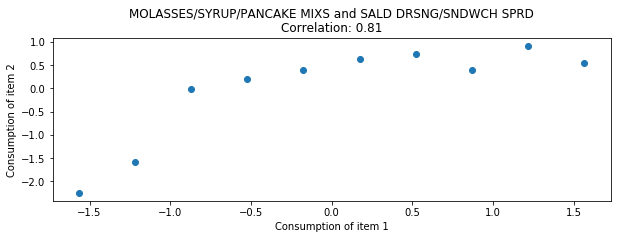

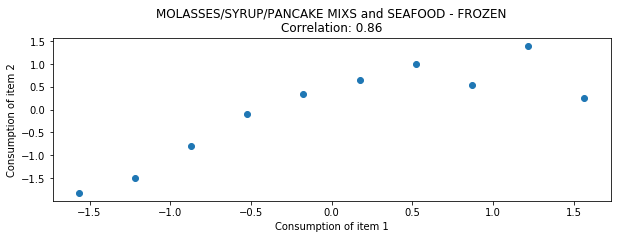

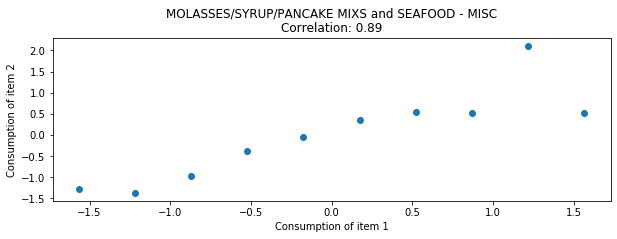

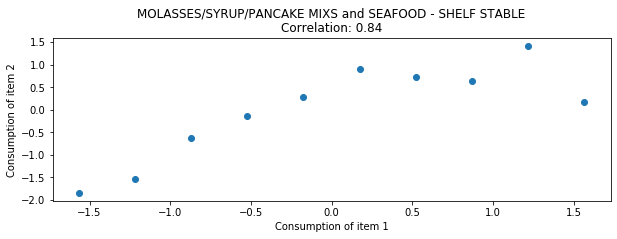

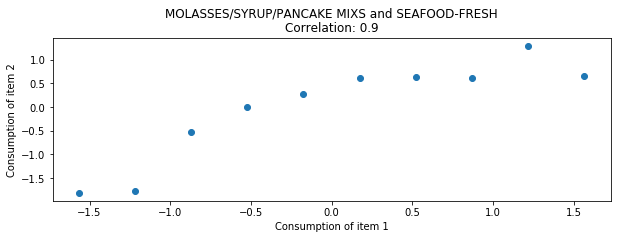

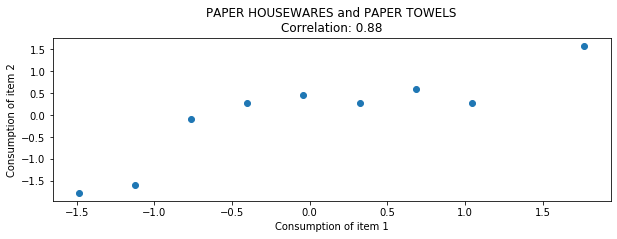

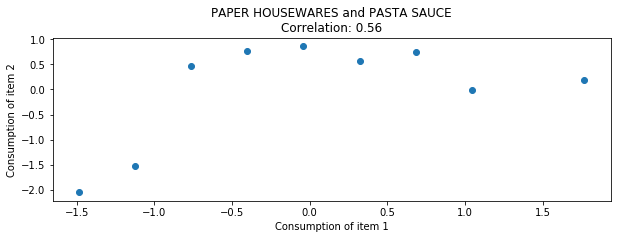

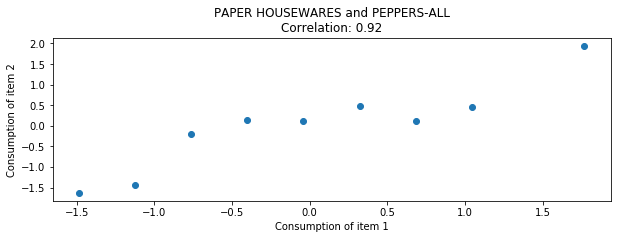

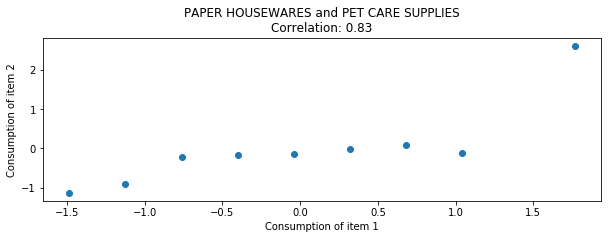

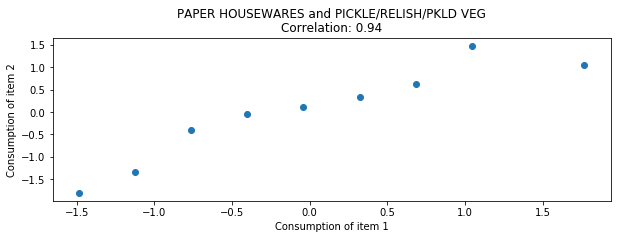

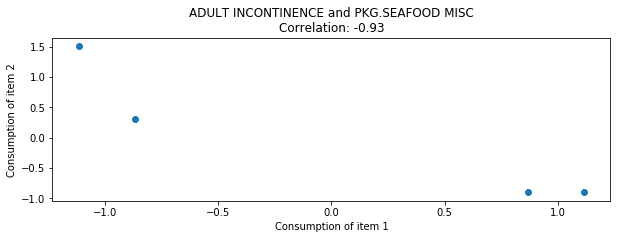

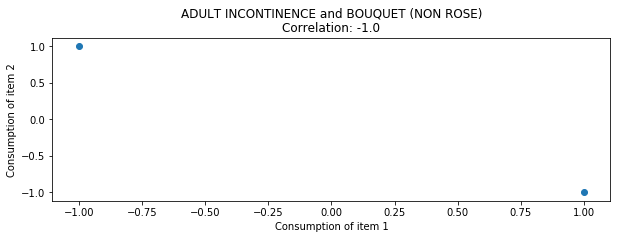

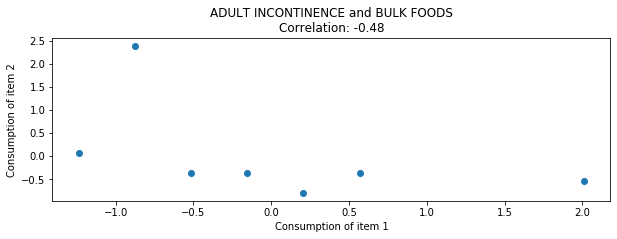

In [107]:
# Form all pairwise combinations
pairs = itertools.combinations(list(df_merged_new.COMMODITY_DESC.unique()), 2)

# Standardizing function
std = StandardScaler()

# Experiment with a few pairs
correlations = {}
for pair in list(pairs)[1900:1905]:
    item1_df = df_merged_new[df_merged_new.COMMODITY_DESC == pair[0]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    item2_df = df_merged_new[df_merged_new.COMMODITY_DESC == pair[1]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    
    # Join by week number -- make sure that we observe along the same time frame
    joined_df = item1_df.join(item2_df, how = 'inner', lsuffix = '_1', rsuffix = '_2')
    joined_df.sort_index(inplace = True)
    
    if joined_df.shape[0] <= 1:
        continue # Need more than one overlapping time indices to compute elasticity!
        
    correlations[(item1_df.COMMODITY_DESC.unique()[0], item2_df.COMMODITY_DESC.unique()[0])] = plot_two_consumptions(joined_df)
#-----------------------------------------------------------------------------------------------------------------------------------------------------#    
# Below is just for plotting a few more examples (can be deleted eventually)
pairs = itertools.combinations(list(df_merged_new.COMMODITY_DESC.unique()), 2)
for pair in list(pairs)[3900:3905]:
    item1_df = df_merged_new[df_merged_new.COMMODITY_DESC == pair[0]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    item2_df = df_merged_new[df_merged_new.COMMODITY_DESC == pair[1]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    
    # Join by week number -- make sure that we observe along the same time frame
    joined_df = item1_df.join(item2_df, how = 'inner', lsuffix = '_1', rsuffix = '_2')
    joined_df.sort_index(inplace = True)
    
    if joined_df.shape[0] <= 1:
        continue # Need more than one overlapping time indices to compute elasticity!
        
    correlations[(item1_df.COMMODITY_DESC.unique()[0], item2_df.COMMODITY_DESC.unique()[0])] = plot_two_consumptions(joined_df)
                                                                                                                     
pairs = itertools.combinations(list(df_merged_new.COMMODITY_DESC.unique()), 2)
for pair in list(pairs)[300:305]:
    item1_df = df_merged_new[df_merged_new.COMMODITY_DESC == pair[0]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    item2_df = df_merged_new[df_merged_new.COMMODITY_DESC == pair[1]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    
    # Join by week number -- make sure that we observe along the same time frame
    joined_df = item1_df.join(item2_df, how = 'inner', lsuffix = '_1', rsuffix = '_2')
    joined_df.sort_index(inplace = True)
    
    if joined_df.shape[0] <= 1:
        continue # Need more than one overlapping time indices to compute elasticity!
        
    correlations[(item1_df.COMMODITY_DESC.unique()[0], item2_df.COMMODITY_DESC.unique()[0])] = plot_two_consumptions(joined_df)
#-----------------------------------------------------------------------------------------------------------------------------------------------------#

We begin to see some clear relationships between certain products. For example, molasses/syrup/pancake mixs are strongly correlated with seafood products. Similarly, paper housewares and other products which seem common, everyday items (like peppers) are strongly correlated. If we filter out all other relationships using a threshold on correlation coefficient somewhere between 0.5 and 0.75, then we may be able to extract only meaningful relationships. 

However, we are interested in knowing whether these relationships occur simply because these items are purchased a lot (in terms of quantity) or because they are purchased frequently (in terms of number of weeks).

In [108]:
# Look for these products in qty_sorted and freq_items
qty_ranking_pancake_mixs = np.where(np.array(qty_sorted.index)=='MOLASSES/SYRUP/PANCAKE MIXS')[0][0]
freq_ranking_pancake_mixs = np.where(np.array(freq_items) == 'MOLASSES/SYRUP/PANCAKE MIXS')[0][0]
print('Pancake mixes ranking in quantities sold: {}, and number of weeks sold: {}'.format(qty_ranking_pancake_mixs, freq_ranking_pancake_mixs))

qty_ranking_paper_housewares = np.where(np.array(qty_sorted.index)=='PAPER HOUSEWARES')[0][0]
freq_ranking_paper_housewares = np.where(np.array(freq_items) == 'PAPER HOUSEWARES')[0][0]
print('Paper housewares ranking in quantities sold: {}, and number of weeks sold: {}'.format(qty_ranking_paper_housewares, freq_ranking_paper_housewares))

qty_ranking_seafood = np.where(np.array(qty_sorted.index)=='SEAFOOD-FRESH')[0][0]
freq_ranking_seafood = np.where(np.array(freq_items) == 'SEAFOOD-FRESH')[0][0]
print('Seafood-fresh ranking in quantities sold: {}, and number of weeks sold: {}'.format(qty_ranking_seafood, freq_ranking_seafood))

Pancake mixes ranking in quantities sold: 124, and number of weeks sold: 59
Paper housewares ranking in quantities sold: 85, and number of weeks sold: 52
Seafood-fresh ranking in quantities sold: 142, and number of weeks sold: 26


Note that even the 59th place in the frequency ranking is a product which is bought every week in the two years. So we notice that two products' total consumption is strongly correlated only between products which are bought every week. Therefore, the correlation method is not significantly different from the simple ranking method.

However, the correlation method does not in general tell us whether the two products are actually frequently bought *together*. It reflects that individual items are frequently bought *independently*. It is still very plausible, for example, that pancake mixes and seafood products are often purchased together, but the correlation method is not a direct method to identify co-purchases per se.

### F) Constructing a "co-purchase" matrix

If we can identify *pairs* of products which are bought frequently (e.g. weekly), then this would be an interesting story to tell. The way this method differs from the simple ranking of frequencies of product purchases is that now we consider whether or not two products are **co-purchased**. It is highly likely that a product which we know is bought every week will also show up in this analysis. However, with this method we will have verified that it is not only purchased frequently on its own, it is frequently purchased together with other products.

In [109]:
# Copy df_baskets from part (A)
basket_of_goods = df_baskets.copy() 
print('Shape: ', basket_of_goods.shape)
print('Number of unique baskets: ', len(basket_of_goods.BASKET_ID.unique()))
basket_of_goods.head()

Shape:  (2576814, 8)
Number of unique baskets:  275539


,BASKET_ID,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,26984851472,1004906,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB
1,26984851472,1033142,2,PRODUCE,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB
2,26984851472,1036325,69,PRODUCE,Private,VEGETABLES - ALL OTHERS,CELERY,
3,26984851472,1082185,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB
4,26984851472,8160430,69,PRODUCE,Private,ORGANICS FRUIT & VEGETABLES,ORGANIC CARROTS,1 LB


In [110]:
# For each basket ID, compile a list of product description
baskets_and_products = basket_of_goods.groupby('BASKET_ID')['COMMODITY_DESC'].apply(list)
baskets_and_products = baskets_and_products.apply(lambda x: list(set(x))) # Take unique commodities
baskets_and_products.head()

BASKET_ID
26984851472    [VEGETABLES - ALL OTHERS, ORGANICS FRUIT & VEG...
26984851516    [COOKIES/CONES, BROOMS AND MOPS, PNT BTR/JELLY...
26984896261    [BREAKFAST SAUSAGE/SANDWICHES, CRACKERS/MISC B...
26984905972                       [SOUP, BAKED BREAD/BUNS/ROLLS]
26984945254    [CANDY - PACKAGED, ELECTRICAL SUPPPLIES, CANDY...
Name: COMMODITY_DESC, dtype: object

In [111]:
baskets_and_products2 = baskets_and_products.reset_index()
baskets_and_products2.head()

,BASKET_ID,COMMODITY_DESC
0,26984851472,"[VEGETABLES - ALL OTHERS, ORGANICS FRUIT & VEG..."
1,26984851516,"[COOKIES/CONES, BROOMS AND MOPS, PNT BTR/JELLY..."
2,26984896261,"[BREAKFAST SAUSAGE/SANDWICHES, CRACKERS/MISC B..."
3,26984905972,"[SOUP, BAKED BREAD/BUNS/ROLLS]"
4,26984945254,"[CANDY - PACKAGED, ELECTRICAL SUPPPLIES, CANDY..."


In [112]:
baskets_and_products2['COUNT'] = baskets_and_products2['COMMODITY_DESC'].apply(lambda x: len(x))
baskets_and_products2.head()

,BASKET_ID,COMMODITY_DESC,COUNT
0,26984851472,"[VEGETABLES - ALL OTHERS, ORGANICS FRUIT & VEG...",5
1,26984851516,"[COOKIES/CONES, BROOMS AND MOPS, PNT BTR/JELLY...",4
2,26984896261,"[BREAKFAST SAUSAGE/SANDWICHES, CRACKERS/MISC B...",5
3,26984905972,"[SOUP, BAKED BREAD/BUNS/ROLLS]",2
4,26984945254,"[CANDY - PACKAGED, ELECTRICAL SUPPPLIES, CANDY...",3


In [113]:
ub = np.percentile(baskets_and_products2.COUNT.values, 75)
lb = np.percentile(baskets_and_products2.COUNT.values, 25)
baskets_and_products_filtered = baskets_and_products2[(baskets_and_products2['COUNT'] >= lb) \
                                              & (baskets_and_products2['COUNT'] <= ub)]
baskets_and_products_filtered.head()

,BASKET_ID,COMMODITY_DESC,COUNT
0,26984851472,"[VEGETABLES - ALL OTHERS, ORGANICS FRUIT & VEG...",5
1,26984851516,"[COOKIES/CONES, BROOMS AND MOPS, PNT BTR/JELLY...",4
2,26984896261,"[BREAKFAST SAUSAGE/SANDWICHES, CRACKERS/MISC B...",5
3,26984905972,"[SOUP, BAKED BREAD/BUNS/ROLLS]",2
4,26984945254,"[CANDY - PACKAGED, ELECTRICAL SUPPPLIES, CANDY...",3


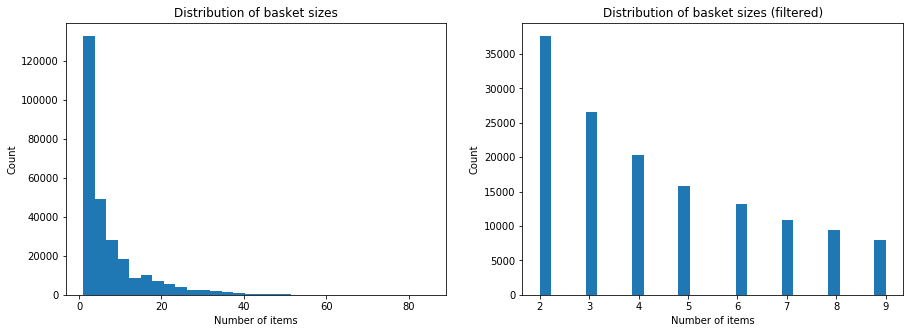

In [114]:
# Some basic analysis
fig, ax = plt.subplots(1,2,figsize=(15,5))
basket_sizes = baskets_and_products.apply(lambda x: len(x)).values
ax[0].hist(basket_sizes, bins=30)
ax[0].set_title('Distribution of basket sizes')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Number of items')

basket_sizes_filetered = baskets_and_products_filtered.COUNT.values
ax[1].hist(basket_sizes_filetered, bins=30)
ax[1].set_title('Distribution of basket sizes (filtered)')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Number of items')

plt.show()

The distribution makes sense since we expect that people don't buy so many items at once.

Now we want to construct a co-occurence matrix of product description.

In [115]:
def generate_co_purchase_matrix(df):
    unique_items = sorted(list(set(itertools.chain.from_iterable(df.values)))) # alphabetical
    
    # Initialize matrix
    co_purchase_matrix = np.zeros((len(unique_items), len(unique_items)))
    basket_counts = dict(zip(unique_items, np.zeros(len(unique_items))))
    
    # Iterate over each basket
    for b in df:
        tmp_indices = [unique_items.index(i) for i in b] # Find indices of all items in the basket
        for i in b:
            basket_counts[i] += 1/2 # Update number of baskets for each item (divide by 2 to get annual average)
            
        pairs = itertools.combinations(tmp_indices, 2)   # Form all pairs of indices
        for p in pairs:
            co_purchase_matrix[p[0], p[1]] += 1
            co_purchase_matrix[p[1], p[0]] += 1
            
    # Divide by 2 to show annual average 
    return co_purchase_matrix/2, unique_items, basket_counts

In [116]:
%%time
# co_purchase_matrix, unique_items, basket_counts = generate_co_purchase_matrix(baskets_and_products)
co_purchase_matrix, unique_items, basket_counts = generate_co_purchase_matrix(baskets_and_products_filtered.COMMODITY_DESC)

# Remove first column and row (index 0 is default '(CORP_USE_ONLY)')
unique_items = unique_items[1:]
co_purchase_matrix = co_purchase_matrix[1:,1:]
basket_counts.pop('(CORP USE ONLY)')

CPU times: user 2.79 s, sys: 2 µs, total: 2.79 s
Wall time: 2.78 s


7.0

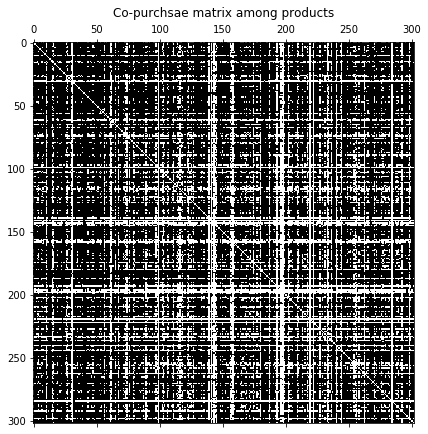

In [117]:
# First examine if the matrix is sparse or dense
plt.figure(figsize=(7,7))
plt.spy(co_purchase_matrix)
plt.title('Co-purchsae matrix among products')
plt.show()

This matrix is symmetric and the diagonal elements are 0 by construction.

The network is quite dense, which means that the vast majority of the products have been purchased together *at least once*. However, it is worth noticing that not all products have been purchased together.

#### Observation 1: products that have *never* or *rarely* been purchased together

In [118]:
tmp_index = np.where(co_purchase_matrix==0)[0]
tmp_index2 = np.where(co_purchase_matrix==0)[1]
products_never_purchased_together = []
for i in range(len(tmp_index)):
    products_never_purchased_together.append((tmp_index[i], tmp_index2[i]))
print('Total fraction of "pairs of products" which are never purchased together: {:0.2f} '.format(\
                        len(products_never_purchased_together)/co_purchase_matrix.shape[0]**2))

Total fraction of "pairs of products" which are never purchased together: 0.30 


Let's look at some of these pairs. Below, we have products which were never purchased together in two years.

In [119]:
for i in range(10):
    p = random.choice(products_never_purchased_together) 
    if p[0]==p[1]: continue
    print('{}--------------------{}'.format(unique_items[p[0]],unique_items[p[1]]))

PKG.SEAFOOD MISC--------------------SALAD MIX
IMPORTED WINE--------------------PKG.SEAFOOD MISC
FRZN SEAFOOD--------------------CITRUS
INFANT FORMULA--------------------EXOTIC GAME/FOWL
BATH--------------------CONTINUITIES
NON EDIBLE PRODUCTS--------------------NO COMMODITY DESCRIPTION
LONG DISTANCE CALLING CARDS--------------------MOLASSES/SYRUP/PANCAKE MIXS
FLORAL-ACCESSORIES--------------------MISCELLANEOUS HBC
FUEL--------------------BOTTLE DEPOSITS
COSMETIC ACCESSORIES--------------------SYRUPS/TOPPINGS


In particular, one may notice that there are "columns" of nearly empty space, which indicates one product which are rarely ever bought with anything. Find out what these are.

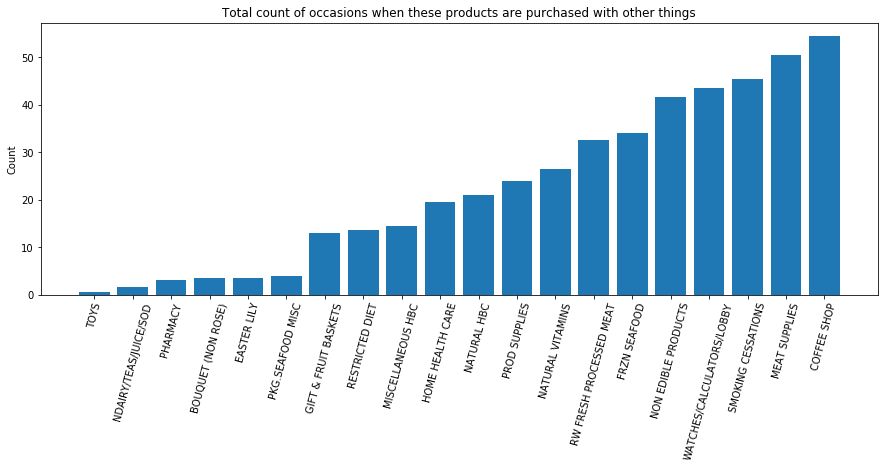

In [120]:
total_purchase_occasions = np.sum(co_purchase_matrix, axis=1)
indices = np.arange(0,len(total_purchase_occasions),1)

rarely_bought_with_anything = sorted(zip(total_purchase_occasions, indices))

x1 = [unique_items[i[1]] for i in rarely_bought_with_anything]
y = [i[0] for i in rarely_bought_with_anything]

# Plot 
N = 20
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(np.arange(0,N,1), y[:N])
ax.set_xticks(np.arange(0,N,1))
ax.set_xticklabels(x1[:N], rotation=75)
ax.set_ylabel('Count')
ax.set_title('Total count of occasions when these products are purchased with other things')
plt.show()

The above plot is the 20 products which are most rarely purchased with anything else in the store. For example, in the 15th place, we have coffee shop, which implies that when people go buy coffee, that's often the only thing they buy. In the first place, we have `NDAIRY/TEAS/JUICE/SOD` which could just be an unpopular product.

##### Business implication:
One important business implication is to investigate whether each of these products are also low in its own sales. For example, `FUEL` is literally *the most selling* product; it's just that people often come just for fuel and not buy anything else. It would therefore be silly to remove `FUEL` from the list of available products. However, if `NDAIRY/TEAS/JUICE/SOD` indeed has a low sale on its own, then the stores can seriously consider removing this item from their stock. 

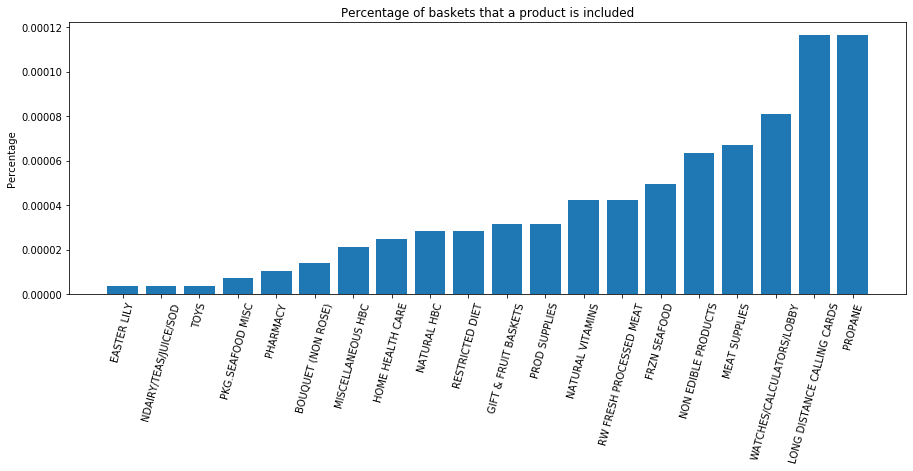

In [121]:
# Find out if some of the above items are low in sales

# num_baskets = baskets_and_products.shape[0]
num_baskets = baskets_and_products_filtered.shape[0]
percent_basket = [x[1]/num_baskets for x in basket_counts.items()]

ascending_basket_counts = sorted(zip(percent_basket, basket_counts.keys()), reverse=False)

x2 = [n[1] for n in ascending_basket_counts]
y = [n[0] for n in ascending_basket_counts]

# Plot top N
N = 20
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(np.arange(0,N,1), y[:N])
ax.set_xticks(np.arange(0,N,1))
ax.set_xticklabels(x2[:N], rotation=75)
ax.set_ylabel('Percentage')
ax.set_title('Percentage of baskets that a product is included')
plt.show()

One obvious example is `MISCELLANEOUS COURTONS` which are rarely purchased with others and also just not purchased enough on its own. `FUEL` and `COFFEE SHOP` for instance are not in the above ranking because they are purchased in large quantities on their own.

In [122]:
# Let's find out how many items are in the bottom N of both "x1" and "x2"
N = 30
to_put_out_of_stock = []
for i in x1[:N]:
    if i in x2[:N]:
        to_put_out_of_stock.append(i)

# Print a few
print(to_put_out_of_stock)

['TOYS', 'NDAIRY/TEAS/JUICE/SOD', 'PHARMACY', 'BOUQUET (NON ROSE)', 'EASTER LILY', 'PKG.SEAFOOD MISC', 'GIFT & FRUIT BASKETS', 'RESTRICTED DIET', 'MISCELLANEOUS HBC', 'HOME HEALTH CARE', 'NATURAL HBC', 'PROD SUPPLIES', 'NATURAL VITAMINS', 'RW FRESH PROCESSED MEAT', 'FRZN SEAFOOD', 'NON EDIBLE PRODUCTS', 'WATCHES/CALCULATORS/LOBBY', 'SMOKING CESSATIONS', 'MEAT SUPPLIES', 'LONG DISTANCE CALLING CARDS', 'COFFEE SHOP SWEET GOODS&RETAIL', 'PROPANE', 'BOTTLE DEPOSITS', 'COUPON', 'FLORAL-ACCESSORIES', 'BABYFOOD', 'VEAL']


These are 30 items which are not bought with other products often, and are also not bought enough on their own. `EASTER LILY` may still be worth keeping as it is a seasonal item. Otherwise, a business may consider putting some of these items out of stock if they are costly to keep.

#### Observation 2: products that are in the most number of baskets

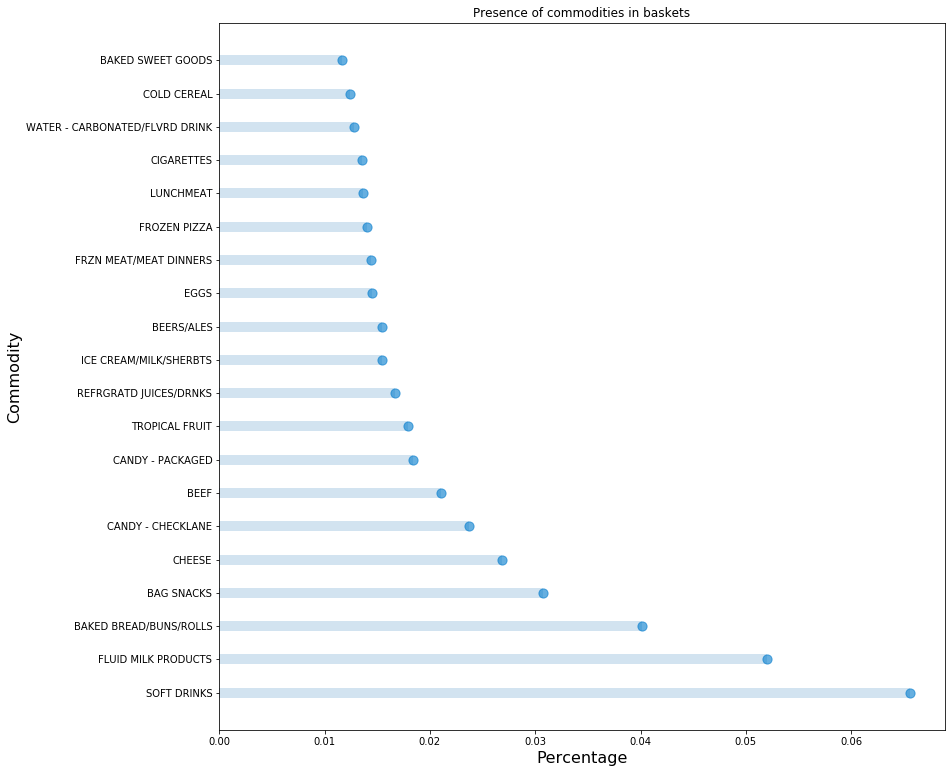

In [123]:
# Percentage of baskets each product is found in
num_baskets = baskets_and_products.shape[0]
percent_basket = [x[1]/num_baskets for x in basket_counts.items()]

sorted_basket_counts = sorted(zip(percent_basket, basket_counts.keys()), reverse=True)
y = [n[0] for n in sorted_basket_counts]
x = [n[1] for n in sorted_basket_counts]

# Plot top N
N = 20
fig, ax = plt.subplots(figsize=(13,13))
ax.barh(np.arange(0,N,1), y[:N], alpha=0.2, height=0.3)
ax.plot(y[:N], np.arange(0,N,1), "o", markersize=9.2, color='#007acc', alpha=0.6)
ax.set_xlabel('Percentage', fontsize=16)
ax.set_ylabel('Commodity', fontsize=16)
ax.set_yticks(np.arange(0,N,1))
ax.set_yticklabels(x[:N])
ax.set_xlabel('Percentage')
ax.set_title('Presence of commodities in baskets')
plt.savefig('plot2.png', dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()

One would expect that products which are purchased in the most number of baskets are cheap, inferior goods (i.e. products whose demand typically decreases when consumer income rises). As expected, we have dairy products, pastry, and many other snacks/cheap food products in the top 20 ranking, all of which are typical inferior goods.

It's also noteworthy that the most commonly seen product is only in about 13% of all the baskets in an average year.

#### Observation 3: making the matrix sparse


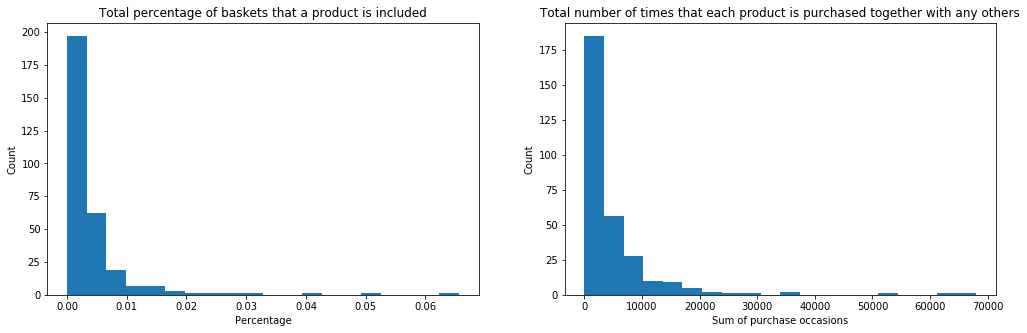

In [124]:
fig, ax = plt.subplots(1,2,figsize=(17,5))
ax[0].hist(y, bins=20)
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Percentage')
ax[0].set_title('Total percentage of baskets that a product is included')

ax[1].hist(np.sum(co_purchase_matrix, axis=1), bins=20)
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Sum of purchase occasions')
ax[1].set_title('Total number of times that each product is purchased together with any others')

plt.show()


Both distributions are heavily skewed. One strategy is to filter **products** based on the percentiles of the *left* distribution, and to filter **values** of the co-purchase matrix, which is very dense at the moment, based on the percentiles of the *right* distribution. 

In [125]:
# Get the middle 70% of the products
percentile_p = 5
percentile_v = 5
print(str(percentile_p)+'th percentile of the left histogram above: ', np.percentile(y,percentile_p))
print(str(100-percentile_p)+'th percentile of the left histogram above: ', np.percentile(y,100-percentile_p))

print(str(percentile_v)+'th percentile of the right histogram above: ', np.percentile(sum(co_purchase_matrix),percentile_v))
print(str(100-percentile_v)+'th percentile of the right histogram above: ', np.percentile(sum(co_purchase_matrix),100-percentile_v))

5th percentile of the left histogram above:  3.275398400952316e-05
95th percentile of the left histogram above:  0.01366412740120273
5th percentile of the right histogram above:  41.6
95th percentile of the right histogram above:  16496.974999999995


In [126]:
def product_sparse_co_purchase_matrix(matrix, lb, ub, percentages, list_items):
    sparsed = np.copy(matrix)
    ind_ub = percentages > ub # upper
    ind_lb = percentages < lb # lower
    ind = ind_ub + ind_lb
    
    sparsed = sparsed[~ind,:][:,~ind]
    return sparsed, np.array(list_items)[~ind]
    
def value_sparse_co_purchase_matrix(matrix, lb, ub):
    sparsed = np.copy(matrix)
    # upper
    ind = sparsed >= ub
    sparsed[ind] = 0
    # lower
    ind = sparsed <= lb
    sparsed[ind] = 0
    return sparsed
    

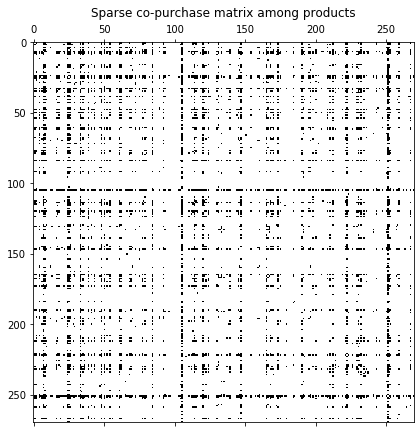

In [150]:
# Use percentiles as thresholds
th1 = np.percentile(y, percentile_p)
th2 = np.percentile(y, 100 - percentile_p)
sparse_matrix, sparse_unique_items = product_sparse_co_purchase_matrix(co_purchase_matrix, th1, th2, y, unique_items)

th1 = np.percentile(sum(co_purchase_matrix), percentile_v)
th2 = np.percentile(sum(co_purchase_matrix), 100 - percentile_v)
sparse_matrix = value_sparse_co_purchase_matrix(sparse_matrix, th1, th2)

plt.figure(figsize=(7,7))
plt.spy(sparse_matrix)
plt.title('Sparse co-purchase matrix among products')
plt.show()

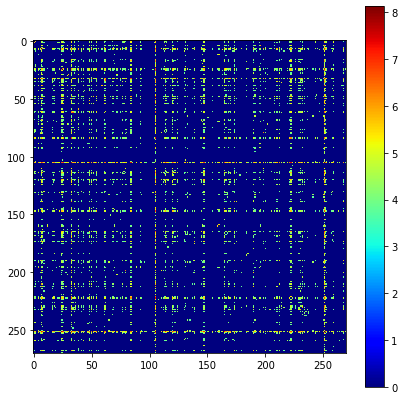

In [153]:
# Trying to add 1 everywhere on sparse_matrix and log regularization
fig = plt.figure(figsize=(7,7))

obj = plt.imshow(np.log(sparse_matrix+ 1), cmap='jet')

fig.colorbar(obj)
plt.savefig('plot3.png', dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()

The implication of filtering counts in this way is that now we look only at the middle 70% of the products based on their number of purchases with other products.

#### Basic network analysis 

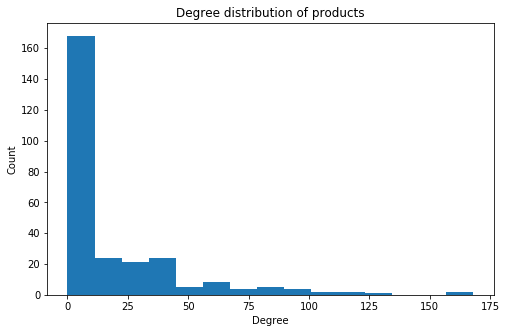

Average degree =  18.511111111111113
Maximum degree =  168


In [128]:
# Visualize degree distribution
degrees = sum(1*(sparse_matrix>0))
plt.figure(figsize=(8,5))
plt.hist(degrees, bins=15)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree distribution of products')
plt.show()

print('Average degree = ', np.mean(degrees))
print('Maximum degree = ', np.max(degrees))

On average, a product is connected with 9 other products in a given year. The degree of the product with the highest degree, i.e. the product which have been purchased with the greatest number of other products, is connected to 79 products.

In [129]:
# Let's identify the products with the greatest degrees
indices = np.arange(0,len(degrees),1)
sorted_degrees = [x[0] for x in sorted(zip(degrees, indices), reverse=True)]
sorted_indices = [x[1] for x in sorted(zip(degrees, indices), reverse=True)]

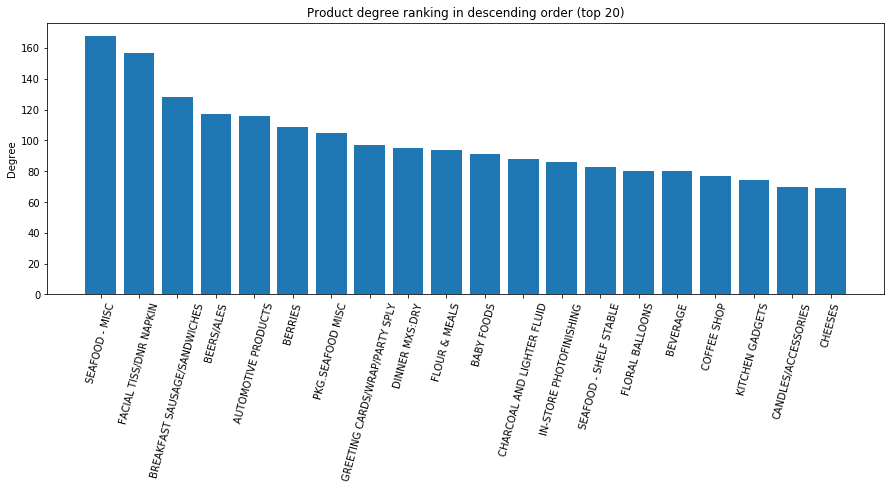

In [130]:
x = [unique_items[j] for j in sorted_indices]

N = 20
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(np.arange(0,N,1), sorted_degrees[:N])
ax.set_xticks(np.arange(0,N,1))
ax.set_xticklabels(x[:N], rotation=75)
ax.set_ylabel('Degree')
ax.set_title('Product degree ranking in descending order (top ' + str(N) + ')')
plt.show()

Let's find out if the sparse matrix truly consists of *one* connected component.

In [131]:
G = nx.from_numpy_matrix(sparse_matrix.astype(int), parallel_edges=True)
print('Is the network connected? ', nx.is_connected(G))

print('Number of disjoint components: ', nx.number_connected_components(G))

Is the network connected?  False
Number of disjoint components:  93


In [132]:
for i,el in enumerate(sparse_unique_items):
    G.nodes[i]["name"] = el

In [133]:
G.nodes[169]["name"]

'MEAT - MISC'

Our network is disconnected due to many products which are never purchased together with any other products. So we need to extract the giant component.

In [134]:
import networkx as nx

from bokeh.io import show, output_file
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4

from bokeh.io import show, output_file
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, BoxZoomTool, ResetTool
from bokeh.models.graphs import from_networkx
from bokeh.palettes import Spectral4

plot = Plot(plot_width=800, plot_height=800,
            x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))

#plot.add_tools(HoverTool(tooltips=None), )
node_hover_tool = HoverTool(tooltips=[("name", "@name")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool(), TapTool(), BoxSelectTool())


#graph_renderer = from_networkx(G, nx.spiral_layout, scale=1, center=(0,0))
nb_nodes = len(G.nodes)
shells = [list(range(0, nb_nodes // 3)), list(range(nb_nodes // 3, nb_nodes))]
graph_renderer = from_networkx(G, nx.shell_layout, nlist=shells, scale=1, center=(0,0))

graph_renderer.node_renderer.glyph = Circle(size=10, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=10, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=10, fill_color=Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#FFFFFF", line_alpha=0.8, line_width=2.5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=2.5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=2.5)

graph_renderer.selection_policy  = NodesAndLinkedEdges()
#graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)

output_file("interactive_graphs.html")
show(plot)

In [135]:
from bokeh.embed import components
script, div = components(plot)

outFile = open("interactive_graphs_script.html",'w+')
outFile.write(script)
outFile.close()

outFile2 = open("interactive_graphs_div.html",'w+')
outFile2.write(div)
outFile2.close()

In [137]:
# Get all components and keep track of their sizes
product_components = {} # Collect unique components
component_sizes = {}    # Keep track of each component's size
for i,g in enumerate(nx.connected_components(G)):
    product_components[i] = g
    component_sizes[i] = len(g)

print(list(component_sizes.values()))
#print('Number of unique sizes: ', set(component_sizes.values()))

[1, 178, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


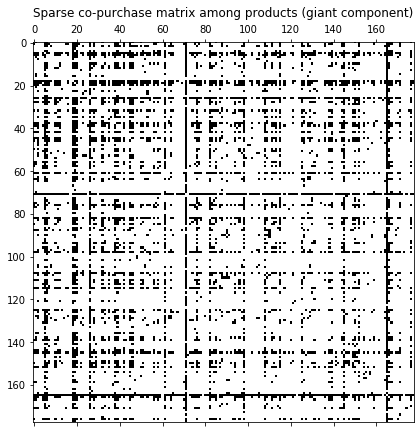

In [138]:
# Extract giant component
giant_component_ids = list(product_components[np.argmax(list(component_sizes.values()))])
giant_component_products = list(np.array(list(sparse_unique_items))[giant_component_ids])
giant_component = sparse_matrix[:,giant_component_ids][giant_component_ids,:]

plt.figure(figsize=(7,7))
plt.spy(giant_component)
plt.title('Sparse co-purchase matrix among products (giant component)')
plt.show()

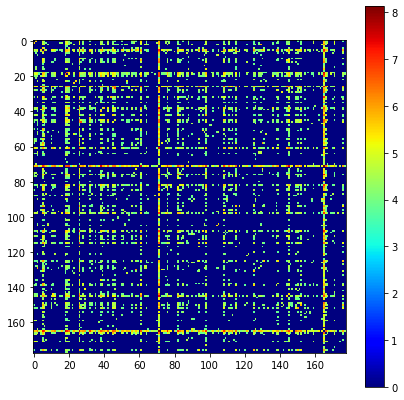

In [139]:
# Trying to add 1 everywhere on giant_component array and log regularization
fig = plt.figure(figsize=(7,7))

obj = plt.imshow(np.log(giant_component + 1), cmap='jet')

fig.colorbar(obj)
plt.show()

In general, we are interested in finding any (possibly small) "blocks" or "clusters" of bright colors. We don't seem to have any large groups, but may have some few small groups.

#### Identifying and removing "bridges"

In [140]:
G_giant = nx.from_numpy_array(giant_component)
bridges = nx.bridges(G_giant)

G_unbridged = G_giant.copy()
print('Original size: ', G_unbridged.number_of_nodes())
single_edge_nodes = []
for i,b in enumerate(list(bridges)):
    single_edge_nodes.append((b[0],b[1]))
    G_unbridged.remove_edge(b[0], b[1])
print('Number of bridges: ', i+1)
    
print('Number of disjoint components: ', nx.number_connected_components(G_unbridged))


Original size:  178
Number of bridges:  14
Number of disjoint components:  15


In [141]:
product_components = {} # Collect unique components
component_sizes = {}    # Keep track of each component's size
for i,g in enumerate(nx.connected_components(G_unbridged)):
    product_components[i] = g
    component_sizes[i] = len(g)

print(list(component_sizes.values()))

[164, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [142]:
# Let's find out these "single-edge products"
for p in single_edge_nodes:
    if p[0] not in product_components[0]:
        print('Removed product: {} ---------->{}'. format(giant_component_products[p[0]], giant_component_products[p[1]]))
    else:
        print('Removed product: {} ---------->{}'. format(giant_component_products[p[1]], giant_component_products[p[0]]))

Removed product: CANDLES/ACCESSORIES ---------->SOFT DRINKS
Removed product: EASTER ---------->CANDY - PACKAGED
Removed product: SNACKS ---------->CHEESES
Removed product: CHIPS&SNACKS ---------->SOFT DRINKS
Removed product: FUEL ---------->CIGARETTES
Removed product: FILM AND CAMERA PRODUCTS ---------->SOFT DRINKS
Removed product: FRZN FRUITS ---------->FLUID MILK PRODUCTS
Removed product: NUTS ---------->FLUID MILK PRODUCTS
Removed product: FROZEN ---------->REFRIGERATED
Removed product: ROSES ---------->GREETING CARDS/WRAP/PARTY SPLY
Removed product: SYRUPS/TOPPINGS ---------->ICE CREAM/MILK/SHERBTS
Removed product: LAXATIVES ---------->SOFT DRINKS
Removed product: MISCELLANEOUS ---------->SOFT DRINKS
Removed product: SANDWICHES ---------->SOFT DRINKS


It turns out that the bridges are all edges connecting to single nodes. Therefore, removing bridges is not an effective way to detect communities. However, we can still identify interesting relationships with these. The following are examples where the product on the right was the *only* other product to which the product on the left was linked.

e.g. `FUEL` -> `CIGARETTES`\
e.g. `ROSES` -> `GREETING CARDS/WRAP/PARTY SPLY`\
e.g. `SANDWICHES` -> `SOFT DRINKS`\
e.g. `CHIPS&SNACKS` -> `SOFT DRINKS`\
e.g. `SYRUPS/TOPPINGS` -> `ICE CREAM/MILK/SHERBTS`

#### Identify interesting cliques

In [143]:
def get_clique_weight(G, nodes):
    '''
    Compute total weight of a clique (nodes) normalized by the number of nodes.
    '''
    total_weight = 0
    pairs = itertools.combinations(nodes, 2)
    for p in pairs:
        weight = G_unbridged.get_edge_data(*p)
        total_weight += weight['weight']
    return np.round(total_weight/len(nodes))

In [144]:
cliques = {}
for i,c in enumerate(nx.find_cliques(G_unbridged)):
    if (len(c) > 5) & (len(c) < 10):
        cliques[i] = (c,len(c))

In [145]:
# Let's look at cliques which are between 5 and 10 n in length
for k,c in cliques.items():
    score = get_clique_weight(G_unbridged, c[0])
    print('Clique '+str(k)+':')
    for i in c[0]:
        print(giant_component_products[i])
    print('Clique "density": ', score)
    print('\n')

Clique 4:
SOFT DRINKS
FLUID MILK PRODUCTS
PET CARE SUPPLIES
CANDY - CHECKLANE
DOG FOODS
CAT FOOD
Clique "density":  1406.0


Clique 5:
SOFT DRINKS
FLUID MILK PRODUCTS
PIES
ICE CREAM/MILK/SHERBTS
FROZEN PIE/DESSERTS
BEEF
Clique "density":  1584.0


Clique 8:
SOFT DRINKS
FLUID MILK PRODUCTS
BROOMS AND MOPS
HOUSEHOLD CLEANG NEEDS
PAPER TOWELS
DISHWASH DETERGENTS
Clique "density":  898.0


Clique 11:
SOFT DRINKS
FLUID MILK PRODUCTS
CHEESE
IMPORTED WINE
DOMESTIC WINE
BEERS/ALES
Clique "density":  1715.0


Clique 15:
SOFT DRINKS
FLUID MILK PRODUCTS
CHEESE
BEEF
BROCCOLI/CAULIFLOWER
TOMATOES
ONIONS
SALAD MIX
CARROTS
Clique "density":  1881.0


Clique 17:
SOFT DRINKS
FLUID MILK PRODUCTS
CHEESE
BEEF
REFRGRATD JUICES/DRNKS
SMOKED MEATS
POTATOES
EGGS
Clique "density":  2600.0


Clique 312:
SOFT DRINKS
FLUID MILK PRODUCTS
CHEESE
BEEF
MELONS
STONE FRUIT
BERRIES
GRAPES
Clique "density":  1671.0


Clique 313:
SOFT DRINKS
FLUID MILK PRODUCTS
CHEESE
BEEF
SEAFOOD-FRESH
SEAFOOD - FROZEN
POTATOES
BEERS/ALE

Some interesting examples of cliques : <br/>
- Clique 4 : Soft drinks, Fluid milk products, Pet care supplies, Candy–checklane, Dog foods, Cat food <br/>
- Clique 11 : Soft drinks, Fluid milk products, Cheese, Imported wine, Domestic wine, Beers/ales <br/>
- Clique 15 : Soft drinks, Fluid milk products, Cheese, Beef, Broccoli/cauliflower, Tomatoes, Onions, Salad mix, Carrots <br/>
- Clique 322 : Soft drinks, Fluid milk products, Cheese, Popcorn, Candy-checklane, Candy-packaged

Here, we try do some cliques correlation with household income or number of children

In [146]:
clique_income_corr = {}
clique_children_corr = {}

# We want the p-value < 0.05
p_value_cutoff = 0.05

for k, c in cliques.items():
    if c[1] > 1 and c[1] <= 10:
        clique_products = [giant_component_products[i] for i in c[0]]
        income_corr, income_p_value = product_income_corr(clique_products)
        if income_p_value < p_value_cutoff:
            clique_income_corr[k] = income_corr
        children_corr, children_p_value = product_children_corr(clique_products)
        if children_p_value < p_value_cutoff:
            clique_children_corr[k] = children_corr

In [147]:
print('Number of cliques correlated with household income:', len(clique_income_corr))
print('Number of cliques correlated with presence of children:', len(clique_children_corr))

Number of cliques correlated with household income: 19
Number of cliques correlated with presence of children: 0


We can see that there are no cliques which correlate with the presence of children if we want a p-value < 0.5  
But there are quite a few cliques correlated with household income. Let's visualize some of them.

['SOFT DRINKS', 'FLUID MILK PRODUCTS', 'HAND/BODY/FACIAL PRODUCTS', 'ORAL HYGIENE PRODUCTS', 'CANDY - PACKAGED', 'HAIR CARE PRODUCTS', 'MAKEUP AND TREATMENT']
Correlation: 0.8337420487401044


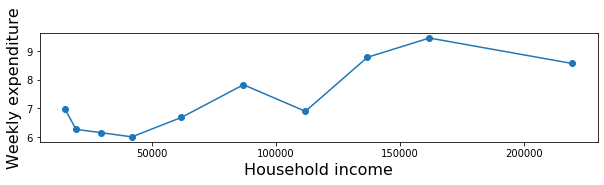

['SOFT DRINKS', 'FLUID MILK PRODUCTS', 'SHAVING CARE PRODUCTS', 'SOAP - LIQUID & BAR', 'CANDY - PACKAGED', 'HAIR CARE PRODUCTS', 'ORAL HYGIENE PRODUCTS', 'HAND/BODY/FACIAL PRODUCTS']
Correlation: 0.8504853864802435


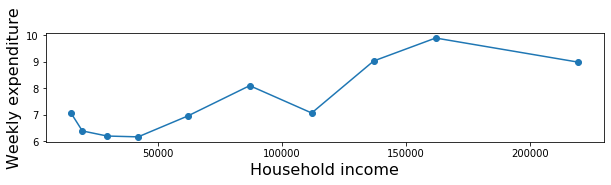

['SOFT DRINKS', 'FLUID MILK PRODUCTS', 'CHEESE', 'IMPORTED WINE', 'DOMESTIC WINE', 'BEERS/ALES']
Correlation: 0.9668731792388134


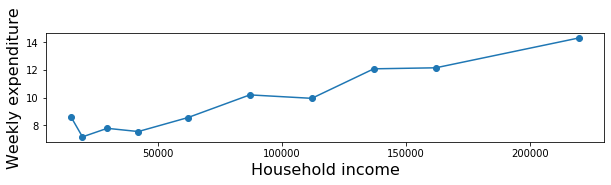

In [148]:
# Display the correlation of the 3 cliques most correlated with household income
for k in sorted(clique_income_corr, key=clique_income_corr.get)[-3:]:
    clique = cliques[k]
    clique_products = [giant_component_products[i] for i in clique[0]]
    print(clique_products)
    print('Correlation:', clique_income_corr[k])
    plot_income_corr(clique_products, title=False)